In [96]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt

# Define the injury threshold (e.g., 120 days)
injury_threshold = 120  # Adjusted as per your requirement

# Filter data between these seasons.
start_season = 2016 
end_season = 2020  # Adjusted to include the desired seasons

# Read player, player_stats, and match CSV files
player = pd.read_csv('mnt/data/player.csv', encoding='ISO-8859-1')
player_stats = pd.read_csv('mnt/data/player_stats.csv', encoding='ISO-8859-1')
match = pd.read_csv('mnt/data/match.csv', encoding='ISO-8859-1')[['match_id', 'match_date', 'season_id']]

# Clean and prepare the match data
match = match.loc[match.match_date != '0000-00-00']  # Remove erroneous data
match['start_year'] = match['season_id'].str[:4].astype(int)  # Create start_year column
match['match_date'] = pd.to_datetime(match['match_date'])  # Convert match_date to datetime
match = match.drop(columns='season_id')  # Drop the 'season_id' column

# Remove non-numeric characters from the substitution_on/off columns
player_stats['substitution_on'] = player_stats['substitution_on'].str.replace("'", "")
player_stats['substitution_off'] = player_stats['substitution_off'].str.replace("'", "")

# Function to convert minutes played based on substitution
def convert_minute(minute_str):
    if pd.isna(minute_str):
        return np.nan
    elif minute_str == 'Null':
        return np.nan
    elif '+' in minute_str:
        minute_str = minute_str.split('+')[1].strip()
        minute_int = int(minute_str) + 90
    else:
        minute_int = int(minute_str)
    return minute_int

player_stats['substitution_on'] = player_stats['substitution_on'].apply(convert_minute)
player_stats['substitution_off'] = player_stats['substitution_off'].apply(convert_minute)

# Merge player_stats with player data using player_id, while also keeping track of sofifa_id
player['p_id2'] = player['player_name'].str.lower().str.replace(' ', '')
player1 = pd.merge(player_stats, player[['p_id2', 'player_name', 'position', 'player_id','sofifa_id']], on='player_id', how='left')

# Merge player1 with match table to get date and start_year of each game played
player2 = pd.merge(player1, match, on='match_id', how='left')

# Filter between seasons we are analyzing
player2 = player2.loc[player2.start_year.between(start_season, end_season)]

# Function to calculate minutes played
def calculate_minutes_played(row):
    if row['is_in_starting_11'] == 1 and pd.isnull(row['substitution_off']):
        return 95  # Assume an average of 5 minutes added time
    elif row['is_in_starting_11'] == 1 and pd.notnull(row['substitution_off']):
        return row['substitution_off']
    elif row['is_in_starting_11'] == 0 and pd.isnull(row['substitution_on']):
        return 0
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.isnull(row['substitution_off']):
        return 95 - row['substitution_on']
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.notnull(row['substitution_off']):
        return row['substitution_off'] - row['substitution_on']

player2['minutes_played'] = player2.apply(calculate_minutes_played, axis=1)

# Create game_played column (1 if minutes_played > 0, else 0)
player2['game_played'] = player2['minutes_played'].apply(lambda x: 1 if x > 0 else 0)

# Change negative values to 0
player2['minutes_played'] = player2['minutes_played'].apply(lambda x: max(0, x))


#Take relevant columns
player3 = player2[['player_id','p_id2', 'position' ,'match_id','match_date', 'start_year','minutes_played','game_played','sofifa_id']]




/var/folders/gb/xt0312dj5f95cvqj6j5hqq2c0000gn/T/ipykernel_6275/2266631427.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  match['match_date'] = pd.to_datetime(match['match_date'])  # Convert match_date to datetime


In [2]:
player3.head()

,player_id,p_id2,position,match_id,match_date,start_year,minutes_played,game_played,sofifa_id
509,p100059,albertomoreno,Defender,14040,2016-08-14,2016.0,95.0,1,205566.0
510,p100059,albertomoreno,Defender,14051,2017-03-12,2016.0,0.0,0,205566.0
511,p100059,albertomoreno,Defender,14067,2016-08-27,2016.0,0.0,0,205566.0
512,p100059,albertomoreno,Defender,14073,2016-09-10,2016.0,2.0,1,205566.0
513,p100059,albertomoreno,Defender,14080,2016-09-16,2016.0,0.0,0,205566.0


In [3]:
# Load the injuries data
injuries = pd.read_csv('mnt/data/injuries_with_sofifa_id.csv', encoding='ISO-8859-1')

# Remove non-alphabetic characters and convert to lowercase
injuries['p_id2'] = injuries['player_name'].replace('[^a-zA-Z]+', '', regex=True).str.lower()

# Extract the starting year from season_injured_id
injuries['start_year'] = injuries['season_injured_id'].str[:4].astype(int)

# Remove injuries related to sickness
injuries = injuries[~injuries['injury'].isin(['Corona virus', 'Ill', 'Cold', 'Food Poisoning', 'Quarantine'])]

# Filter the injury data for relevant seasons
injuries = injuries.loc[injuries['start_year'].between(start_season, end_season)]

#take relevant columns
injuries = injuries[['start_year', 'injury',
       'injured_since', 'injured_until', 'duration_in_days','sofifa_id']]

In [4]:
# --- FIFA Data Handling ---

# Function to clean FIFA data by extracting relevant columns and applying name extraction
def clean_fifa_data(df, year):
    relevant_cols = ['sofifa_id', 'player_url', 'dob', 'height_cm', 'weight_kg', 'nationality', 'work_rate', 'pace', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed' , 'gk_positioning','overall']
    df = df[relevant_cols]
    df['start_year'] = year  # Assign the start year to each row
    return df


# Load and clean FIFA datasets for the relevant years
fifa_files = {
    2016: 'mnt/data/players_16.csv',
    2017: 'mnt/data/players_17.csv',
    2018: 'mnt/data/players_18.csv',
    2019: 'mnt/data/players_19.csv',
    2020: 'mnt/data/players_20.csv',
    2021: 'mnt/data/players_21.csv'
}

fifa_dfs = []
for year, file in fifa_files.items():
    df = pd.read_csv(file, encoding='ISO-8859-1')
    df = clean_fifa_data(df, year)  # Clean the data and add the 'start_year'
    fifa_dfs.append(df)

/var/folders/gb/xt0312dj5f95cvqj6j5hqq2c0000gn/T/ipykernel_6275/3415227862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_year'] = year  # Assign the start year to each row
/var/folders/gb/xt0312dj5f95cvqj6j5hqq2c0000gn/T/ipykernel_6275/3415227862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_year'] = year  # Assign the start year to each row
/var/folders/gb/xt0312dj5f95cvqj6j5hqq2c0000gn/T/ipykernel_6275/3415227862.py:7: SettingWithCopyWarning: 
A value is trying to be set on

In [5]:
# Concatenate all FIFA data into a single dataframe
fifa_all = pd.concat(fifa_dfs, ignore_index=True)

# Group by sofifa_id and start_year to calculate mean (for numerical) and mode (for categorical)
grouped_fifa = fifa_all.groupby(['sofifa_id', 'start_year'])
fifa_final = grouped_fifa.agg(lambda x: x.mean() if x.dtype in ['float64', 'int64'] else x.mode()[0]).reset_index()

# Rename the 'overall' column to 'fifa_rating' for clarity
fifa_final = fifa_final.rename(columns={'overall': 'fifa_rating'})

#take only relevant columns
fifa_final = fifa_final[['sofifa_id','start_year','dob', 'height_cm', 'weight_kg',
       'nationality', 'work_rate', 'pace', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'fifa_rating']]

In [6]:
fifa_final.head()

,sofifa_id,start_year,dob,height_cm,weight_kg,nationality,work_rate,pace,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,fifa_rating
0,2,2016,1982-01-05,182.0,72.0,Italy,Medium/High,71.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,69.0
1,16,2017,1981-02-06,177.0,69.0,Spain,Medium/Medium,61.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0
2,16,2018,1981-02-06,178.0,65.0,Spain,Medium/Medium,54.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0
3,16,2019,1981-02-06,178.0,65.0,Spain,Medium/Medium,53.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0
4,27,2016,1981-11-08,176.0,73.0,England,High/Low,56.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0


In [7]:
print('Unique players in player dataframe:',player3.player_id.nunique())
print('Unique players in injury dataframe:',injuries.sofifa_id.nunique())
print('Unique players in FIFA dataframe:', fifa_final.sofifa_id.nunique())


Unique players in player dataframe: 1414
Unique players in injury dataframe: 1141
Unique players in FIFA dataframe: 38374


In [8]:
# Perform the merge to add player_id to fifa based on the common sofifa_id
fifa_with_player_id = pd.merge(fifa_final, player[['sofifa_id', 'player_id']], on='sofifa_id', how='left')

# Check the resulting dataframe
#print(fifa_with_player_id.head())
#print(f"Number of records in the FIFA file after adding player_id: {fifa_with_player_id.shape[0]}")


In [9]:
# Drop rows from fifa_with_player_id where player_id is NaN
fifa_final_cleaned = fifa_with_player_id.dropna(subset=['player_id'])

# Reset the index if necessary
fifa_final_cleaned.reset_index(drop=True, inplace=True)

# Check the cleaned data
#print(fifa_final_cleaned.head())
#print(f"Number of records after cleaning: {fifa_final_cleaned.shape[0]}")


In [10]:
# Perform the merge to add player_id to injuries based on the common sofifa_id
injuries_with_player_id = pd.merge(injuries, player[['sofifa_id', 'player_id']], on='sofifa_id', how='left')

# Check the resulting dataframe
#print(injuries_with_player_id.head())
#print(f"Number of records in the Injuries file after adding player_id: {injuries_with_player_id.shape[0]}")
#injuries_with_player_id.head()

In [11]:
# Drop rows from fifa_with_player_id where player_id is NaN
injuries_cleaned = injuries_with_player_id.dropna(subset=['sofifa_id'])

# Reset the index if necessary
injuries_cleaned.reset_index(drop=True, inplace=True)

# Check the cleaned data
#print(injuries_cleaned.head())
#print(f"Number of records after cleaning: {injuries_cleaned.shape[0]}")

In [12]:
fifa_final_cleaned = fifa_final_cleaned[['player_id', 'start_year', 'dob', 'height_cm', 'weight_kg',
       'nationality', 'work_rate', 'pace', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'fifa_rating']]

In [13]:
injuries_cleaned = injuries_cleaned[[ 'start_year', 'injury', 'injured_since', 'injured_until',
       'duration_in_days', 'player_id' ]]

In [14]:
# Aggregate the injury data by summing the duration_in_days for each player in each start_year
df_injuries_grouped = injuries_cleaned.groupby(['player_id', 'start_year']).agg({
    'duration_in_days': 'sum'
}).reset_index()

# Rename the column to better reflect its meaning
df_injuries_grouped = df_injuries_grouped.rename(columns={'duration_in_days': 'season_days_injured'})



In [15]:
df_injuries_grouped.head()

,player_id,start_year,season_days_injured
0,p100059,2017,50
1,p100059,2018,16
2,p100059,2019,151
3,p100059,2020,194
4,p100180,2016,24


In [16]:
# Ensure player4 is grouped and has unique player_id and start_year combinations
player4_grouped = player3.groupby(['player_id', 'start_year']).agg({
    'minutes_played': 'sum',
    'game_played': 'sum',
    'match_id': 'count'
}).reset_index()

# Rename columns to match expected output
player4_grouped = player4_grouped.rename(columns={
    'minutes_played': 'season_minutes_played',
    'game_played': 'season_games_played',
    'match_id': 'season_matches_in_squad'
})


# Merge the injury data with the grouped player data
df1 = df_injuries_grouped.merge(player4_grouped, on=['player_id', 'start_year'], how='inner') 

# Merge with FIFA data
df2 = df1.merge(fifa_final_cleaned, on=['player_id', 'start_year'], how='inner')

# Add the position column by merging with the player dataframe
player_clean = player.drop_duplicates(subset=['player_id'])
df_final = df2.merge(player_clean[['player_id', 'position']], on='player_id', how='inner')

# Now, calculate total_minutes_played and total_games_played using df_final data
total_minutes_played = df_final.groupby('player_id')['season_minutes_played'].sum().reset_index().rename(columns={'season_minutes_played': 'total_minutes_played'})
total_games_played = df_final.groupby('player_id')['season_games_played'].sum().reset_index().rename(columns={'season_games_played': 'total_games_played'})

# Merge these totals back into the final dataframe
df_final = df_final.merge(total_minutes_played, on='player_id', how='left')
df_final = df_final.merge(total_games_played, on='player_id', how='left')

# Print the final number of unique players and check the output
print('Final number of players to be analyzed:', df_final['player_id'].nunique())



Final number of players to be analyzed: 723


In [17]:
# Step 1: Aggregate the injury data by summing the duration_in_days for each player in each start_year
aggregated_injuries = df_final.groupby(['player_id']).agg({
    'season_days_injured': 'sum'
}).reset_index()

# Step 2: Rename the aggregated column to better reflect its meaning
aggregated_injuries = aggregated_injuries.rename(columns={'season_days_injured': 'total_days_injured'})

# Step 3: Merge the aggregated data back with the original dataframe to retain all columns
df_final = pd.merge(df_final, aggregated_injuries, on=['player_id'], how='left')

# Check the final dataframe
df_final.head()


,player_id,start_year,season_days_injured,season_minutes_played,season_games_played,season_matches_in_squad,dob,height_cm,weight_kg,nationality,...,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,fifa_rating,position,total_minutes_played,total_games_played,total_days_injured
0,p100059,2017,50,1344.0,16,24,1992-07-05,171.0,65.0,Spain,...,NaN,NaN,NaN,NaN,NaN,77.0,Defender,1504.0,18,66
1,p100059,2018,16,160.0,2,18,1992-07-05,171.0,65.0,Spain,...,NaN,NaN,NaN,NaN,NaN,76.0,Defender,1504.0,18,66
2,p100180,2017,8,1442.0,23,36,1991-07-15,184.0,78.0,Brazil,...,NaN,NaN,NaN,NaN,NaN,80.0,Defender,2298.0,34,105
3,p100180,2018,97,856.0,11,26,1991-07-15,184.0,78.0,Brazil,...,NaN,NaN,NaN,NaN,NaN,78.0,Defender,2298.0,34,105
4,p100412,2017,12,1631.0,27,31,1991-06-14,180.0,73.0,Peru,...,NaN,NaN,NaN,NaN,NaN,80.0,Midfielder,1631.0,27,12


In [18]:
#print(df_final.columns)


In [19]:
#df_final.head()

In [20]:
# Identify Goalkeepers in the dataset
df_final_goalkeepers = df_final[df_final['position'] == 'Goalkeeper']

# Replace missing 'pace' with 'gk_speed' for goalkeepers
df_final['pace'] = df_final.apply(lambda row: row['gk_speed'] if pd.isnull(row['pace']) and row['position'] == 'Goalkeeper' else row['pace'], axis=1)

# Replace missing 'physic' with an average of other goalkeeper attributes for goalkeepers
goalkeeper_attributes = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_positioning']
df_final['physic'] = df_final.apply(lambda row: row[goalkeeper_attributes].mean() if pd.isnull(row['physic']) and row['position'] == 'Goalkeeper' else row['physic'], axis=1)

# Optionally create a gk_ability feature for goalkeepers
df_final['gk_ability'] = df_final.apply(lambda row: row[goalkeeper_attributes].mean() if row['position'] == 'Goalkeeper' else np.nan, axis=1)

# Optionally create an overall ability feature for all players
non_gk_attributes = ['pace', 'physic', 'fifa_rating']  # Modify this list based on your data
df_final['overall_ability'] = df_final.apply(lambda row: row[goalkeeper_attributes].mean() if row['position'] == 'Goalkeeper' 
                                             else row[non_gk_attributes].mean(), axis=1)

# Handle any remaining missing values in the overall_ability feature
df_final['overall_ability'].fillna(df_final['overall_ability'].mean(), inplace=True)

# Check the resulting dataframe
#print(df_final.head())


/var/folders/gb/xt0312dj5f95cvqj6j5hqq2c0000gn/T/ipykernel_6275/2114261812.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['overall_ability'].fillna(df_final['overall_ability'].mean(), inplace=True)


In [21]:
df_final = df_final[['player_id','start_year','season_days_injured','total_days_injured','season_minutes_played', 'total_minutes_played', 'season_games_played',
       'total_games_played','season_matches_in_squad', 'dob', 'height_cm', 'weight_kg','nationality', 'work_rate', 'pace', 'physic', 'fifa_rating', 'position', 'overall_ability']]

In [22]:
#df_final.head()

In [23]:
df_final.to_csv('fina_data_version_10.csv', index = False)

In [97]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt

In [98]:
df_final = pd.read_csv('fina_data_version_10.csv')

In [99]:
# Check for null values in the dataset
null_values = df_final.isnull().sum()

# Display the columns with null values
#print("Null values in each column:\n", null_values)


In [100]:
'''#Converting work rate into numeric variable where low = 1, medium = 1.5, high = 2. i.e.- High/medium work rate = 3.5
work_rate_map = {'Low': 1, 'Medium': 1.5, 'High': 2}
#df_final['work_rate_numeric'] = df_final['work_rate'].apply(lambda x: sum([work_rate_map[w] for w in x.split('/')]))

#Convert position to numeric variable where number corresponds to position intensity (GK -> defender -> forward -> midfielder)
pos_order = {'Goalkeeper': 0, 'Defender': 1, 'Forward': 2, 'Midfielder': 3}
#df_final['position_numeric'] = df_final['position'].map(pos_order)'''

"#Converting work rate into numeric variable where low = 1, medium = 1.5, high = 2. i.e.- High/medium work rate = 3.5\nwork_rate_map = {'Low': 1, 'Medium': 1.5, 'High': 2}\n#df_final['work_rate_numeric'] = df_final['work_rate'].apply(lambda x: sum([work_rate_map[w] for w in x.split('/')]))\n\n#Convert position to numeric variable where number corresponds to position intensity (GK -> defender -> forward -> midfielder)\npos_order = {'Goalkeeper': 0, 'Defender': 1, 'Forward': 2, 'Midfielder': 3}\n#df_final['position_numeric'] = df_final['position'].map(pos_order)"

In [101]:
'''# Calculate Age
df_final['dob'] = pd.to_datetime(df_final['dob'])
df_final['age'] = df_final['start_year'] - df_final['dob'].dt.year

# Drop the original 'dob' column if no longer needed
df_final.drop('dob', axis=1, inplace=True)

# Calculate Experience
df_final['experience'] = df_final.groupby('player_id')['start_year'].transform(lambda x: x - x.min())
'''
# Calculate Age
df_final['dob'] = pd.to_datetime(df_final['dob'])
df_final['age'] = df_final['start_year'] - df_final['dob'].dt.year

# Drop the original 'dob' column if no longer needed
df_final.drop('dob', axis=1, inplace=True)

# Calculate Experience
df_final['experience'] = df_final.groupby('player_id')['start_year'].transform(lambda x: x - x.min())

In [102]:
df_final.head()

,player_id,start_year,season_days_injured,total_days_injured,season_minutes_played,total_minutes_played,season_games_played,total_games_played,season_matches_in_squad,height_cm,weight_kg,nationality,work_rate,pace,physic,fifa_rating,position,overall_ability,age,experience
0,p100059,2017,50,66,1344.0,1504.0,16,18,24,171.0,65.0,Spain,High/Low,89.0,74.0,77.0,Defender,80.000000,25,0
1,p100059,2018,16,66,160.0,1504.0,2,18,18,171.0,65.0,Spain,High/Low,88.0,74.0,76.0,Defender,79.333333,26,1
2,p100180,2017,8,105,1442.0,2298.0,23,34,36,184.0,78.0,Brazil,High/Medium,80.0,79.0,80.0,Defender,79.666667,26,0
3,p100180,2018,97,105,856.0,2298.0,11,34,26,184.0,78.0,Brazil,High/Medium,78.0,79.0,78.0,Defender,78.333333,27,1
4,p100412,2017,12,12,1631.0,1631.0,27,27,31,180.0,73.0,Peru,High/Medium,91.0,68.0,80.0,Midfielder,79.666667,26,0


In [103]:
df_final.columns

Index(['player_id', 'start_year', 'season_days_injured', 'total_days_injured',
       'season_minutes_played', 'total_minutes_played', 'season_games_played',
       'total_games_played', 'season_matches_in_squad', 'height_cm',
       'weight_kg', 'nationality', 'work_rate', 'pace', 'physic',
       'fifa_rating', 'position', 'overall_ability', 'age', 'experience'],
      dtype='object')

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df_final is dataframe with all features
injury_threshold=120


df_final.reset_index(drop=True, inplace=True)  # Reset index

df_final.reset_index(drop=True, inplace=True) #first reset index

# Custom function to calculate cumulative minutes and games played
def calculate_cumulative(x):
    return x.shift(1).expanding().sum()

# Calculate minutes per game considering all years prior to the current year
df_final['cumulative_minutes_played'] = df_final.groupby('player_id')['season_minutes_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df_final['cumulative_games_played'] = df_final.groupby('player_id')['season_games_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df_final['minutes_per_game_prev_seasons'] = df_final['cumulative_minutes_played'] / df_final['cumulative_games_played']

# Custom function to calculate average of a Series
def calculate_average(x):
    return x.shift(1).expanding().mean()

# Calculate average days injured per season in previous seasons
df_final['avg_days_injured_prev_seasons'] = df_final.groupby('player_id')['season_days_injured'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate average games per season in previous seasons
df_final['avg_games_per_season_prev_seasons'] = df_final.groupby('player_id')['season_games_played'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate the Body Mass Index (BMI)
df_final['bmi'] = df_final['weight_kg'] / (df_final['height_cm'] / 100)**2

# Create a feature indicating if the player had a significant injury in the previous season
#injury_threshold defined previously
prev_season_injury = df_final.groupby('player_id')['season_days_injured'].shift(1)
df_final['significant_injury_prev_season'] = np.where(prev_season_injury.isna(), np.nan, (prev_season_injury >= injury_threshold).astype(int))
df_final['significant_injury_prev_season'].astype('category')

# Calculate cumulative days injured and days injured in the previous season
df_final['cumulative_days_injured'] = df_final.groupby('player_id')['total_days_injured'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df_final['season_days_injured_prev_season'] = df_final.groupby('player_id')['season_days_injured'].shift(1)

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [105]:
df_final.isnull().sum()

player_id                              0
start_year                             0
season_days_injured                    0
total_days_injured                     0
season_minutes_played                  0
total_minutes_played                   0
season_games_played                    0
total_games_played                     0
season_matches_in_squad                0
height_cm                              0
weight_kg                              0
nationality                            0
work_rate                              0
pace                                   0
physic                                 0
fifa_rating                            0
position                               0
overall_ability                        0
age                                    0
experience                             0
cumulative_minutes_played            723
cumulative_games_played              723
minutes_per_game_prev_seasons        731
avg_days_injured_prev_seasons        723
avg_games_per_se

In [106]:
df_final.head()

,player_id,start_year,season_days_injured,total_days_injured,season_minutes_played,total_minutes_played,season_games_played,total_games_played,season_matches_in_squad,height_cm,...,experience,cumulative_minutes_played,cumulative_games_played,minutes_per_game_prev_seasons,avg_days_injured_prev_seasons,avg_games_per_season_prev_seasons,bmi,significant_injury_prev_season,cumulative_days_injured,season_days_injured_prev_season
0,p100059,2017,50,66,1344.0,1504.0,16,18,24,171.0,...,0,NaN,NaN,NaN,NaN,NaN,22.229062,NaN,NaN,NaN
1,p100059,2018,16,66,160.0,1504.0,2,18,18,171.0,...,1,1344.0,16.0,84.000000,50.0,16.0,22.229062,0.0,66.0,50.0
2,p100180,2017,8,105,1442.0,2298.0,23,34,36,184.0,...,0,NaN,NaN,NaN,NaN,NaN,23.038752,NaN,NaN,NaN
3,p100180,2018,97,105,856.0,2298.0,11,34,26,184.0,...,1,1442.0,23.0,62.695652,8.0,23.0,23.038752,0.0,105.0,8.0
4,p100412,2017,12,12,1631.0,1631.0,27,27,31,180.0,...,0,NaN,NaN,NaN,NaN,NaN,22.530864,NaN,NaN,NaN


In [107]:
df_final.to_csv('fina_data_version_11.csv', index = False)

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
df_final_player = pd.read_csv('fina_data_version_11.csv')

In [110]:
physical_features = ['player_id', 'start_year', 'position', 'age',
                     'bmi', 'height_cm', 'weight_kg', 'work_rate' ,'pace', 'physic' ,'season_days_injured']

season_features = ['player_id', 'start_year', 'cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons', 
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season',
                   'season_days_injured']

df_physical = df_final_player[physical_features]
df_season = df_final_player[season_features]

In [111]:
df_season.head()

,player_id,start_year,cumulative_minutes_played,cumulative_games_played,minutes_per_game_prev_seasons,avg_days_injured_prev_seasons,avg_games_per_season_prev_seasons,significant_injury_prev_season,cumulative_days_injured,season_days_injured_prev_season,season_days_injured
0,p100059,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
1,p100059,2018,1344.0,16.0,84.000000,50.0,16.0,0.0,66.0,50.0,16
2,p100180,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,p100180,2018,1442.0,23.0,62.695652,8.0,23.0,0.0,105.0,8.0,97
4,p100412,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [112]:
# Drop 'player_id', 'work_rate', 'nationality', and 'position' columns
df_no_id = df_final_player.drop(columns=['player_id', 'work_rate', 'nationality', 'position'])
# Calculate the correlation matrix for the remaining numeric columns
correlation_matrix = df_no_id.corr()


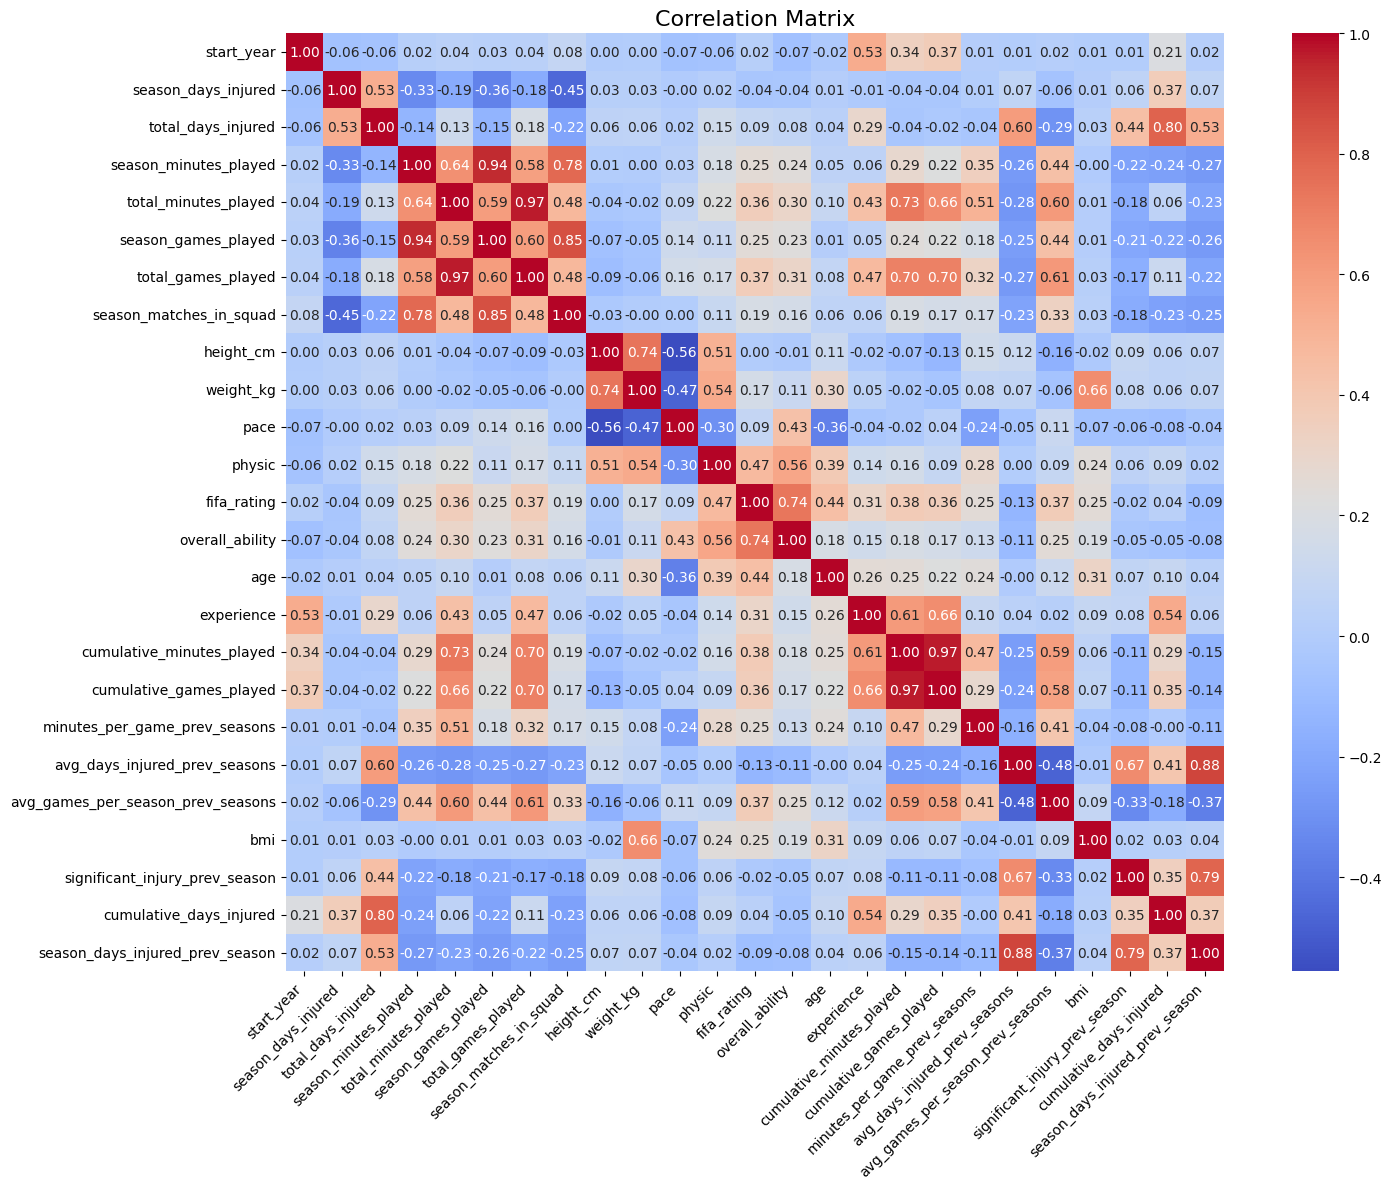

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 10})

# Title and layout adjustments
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


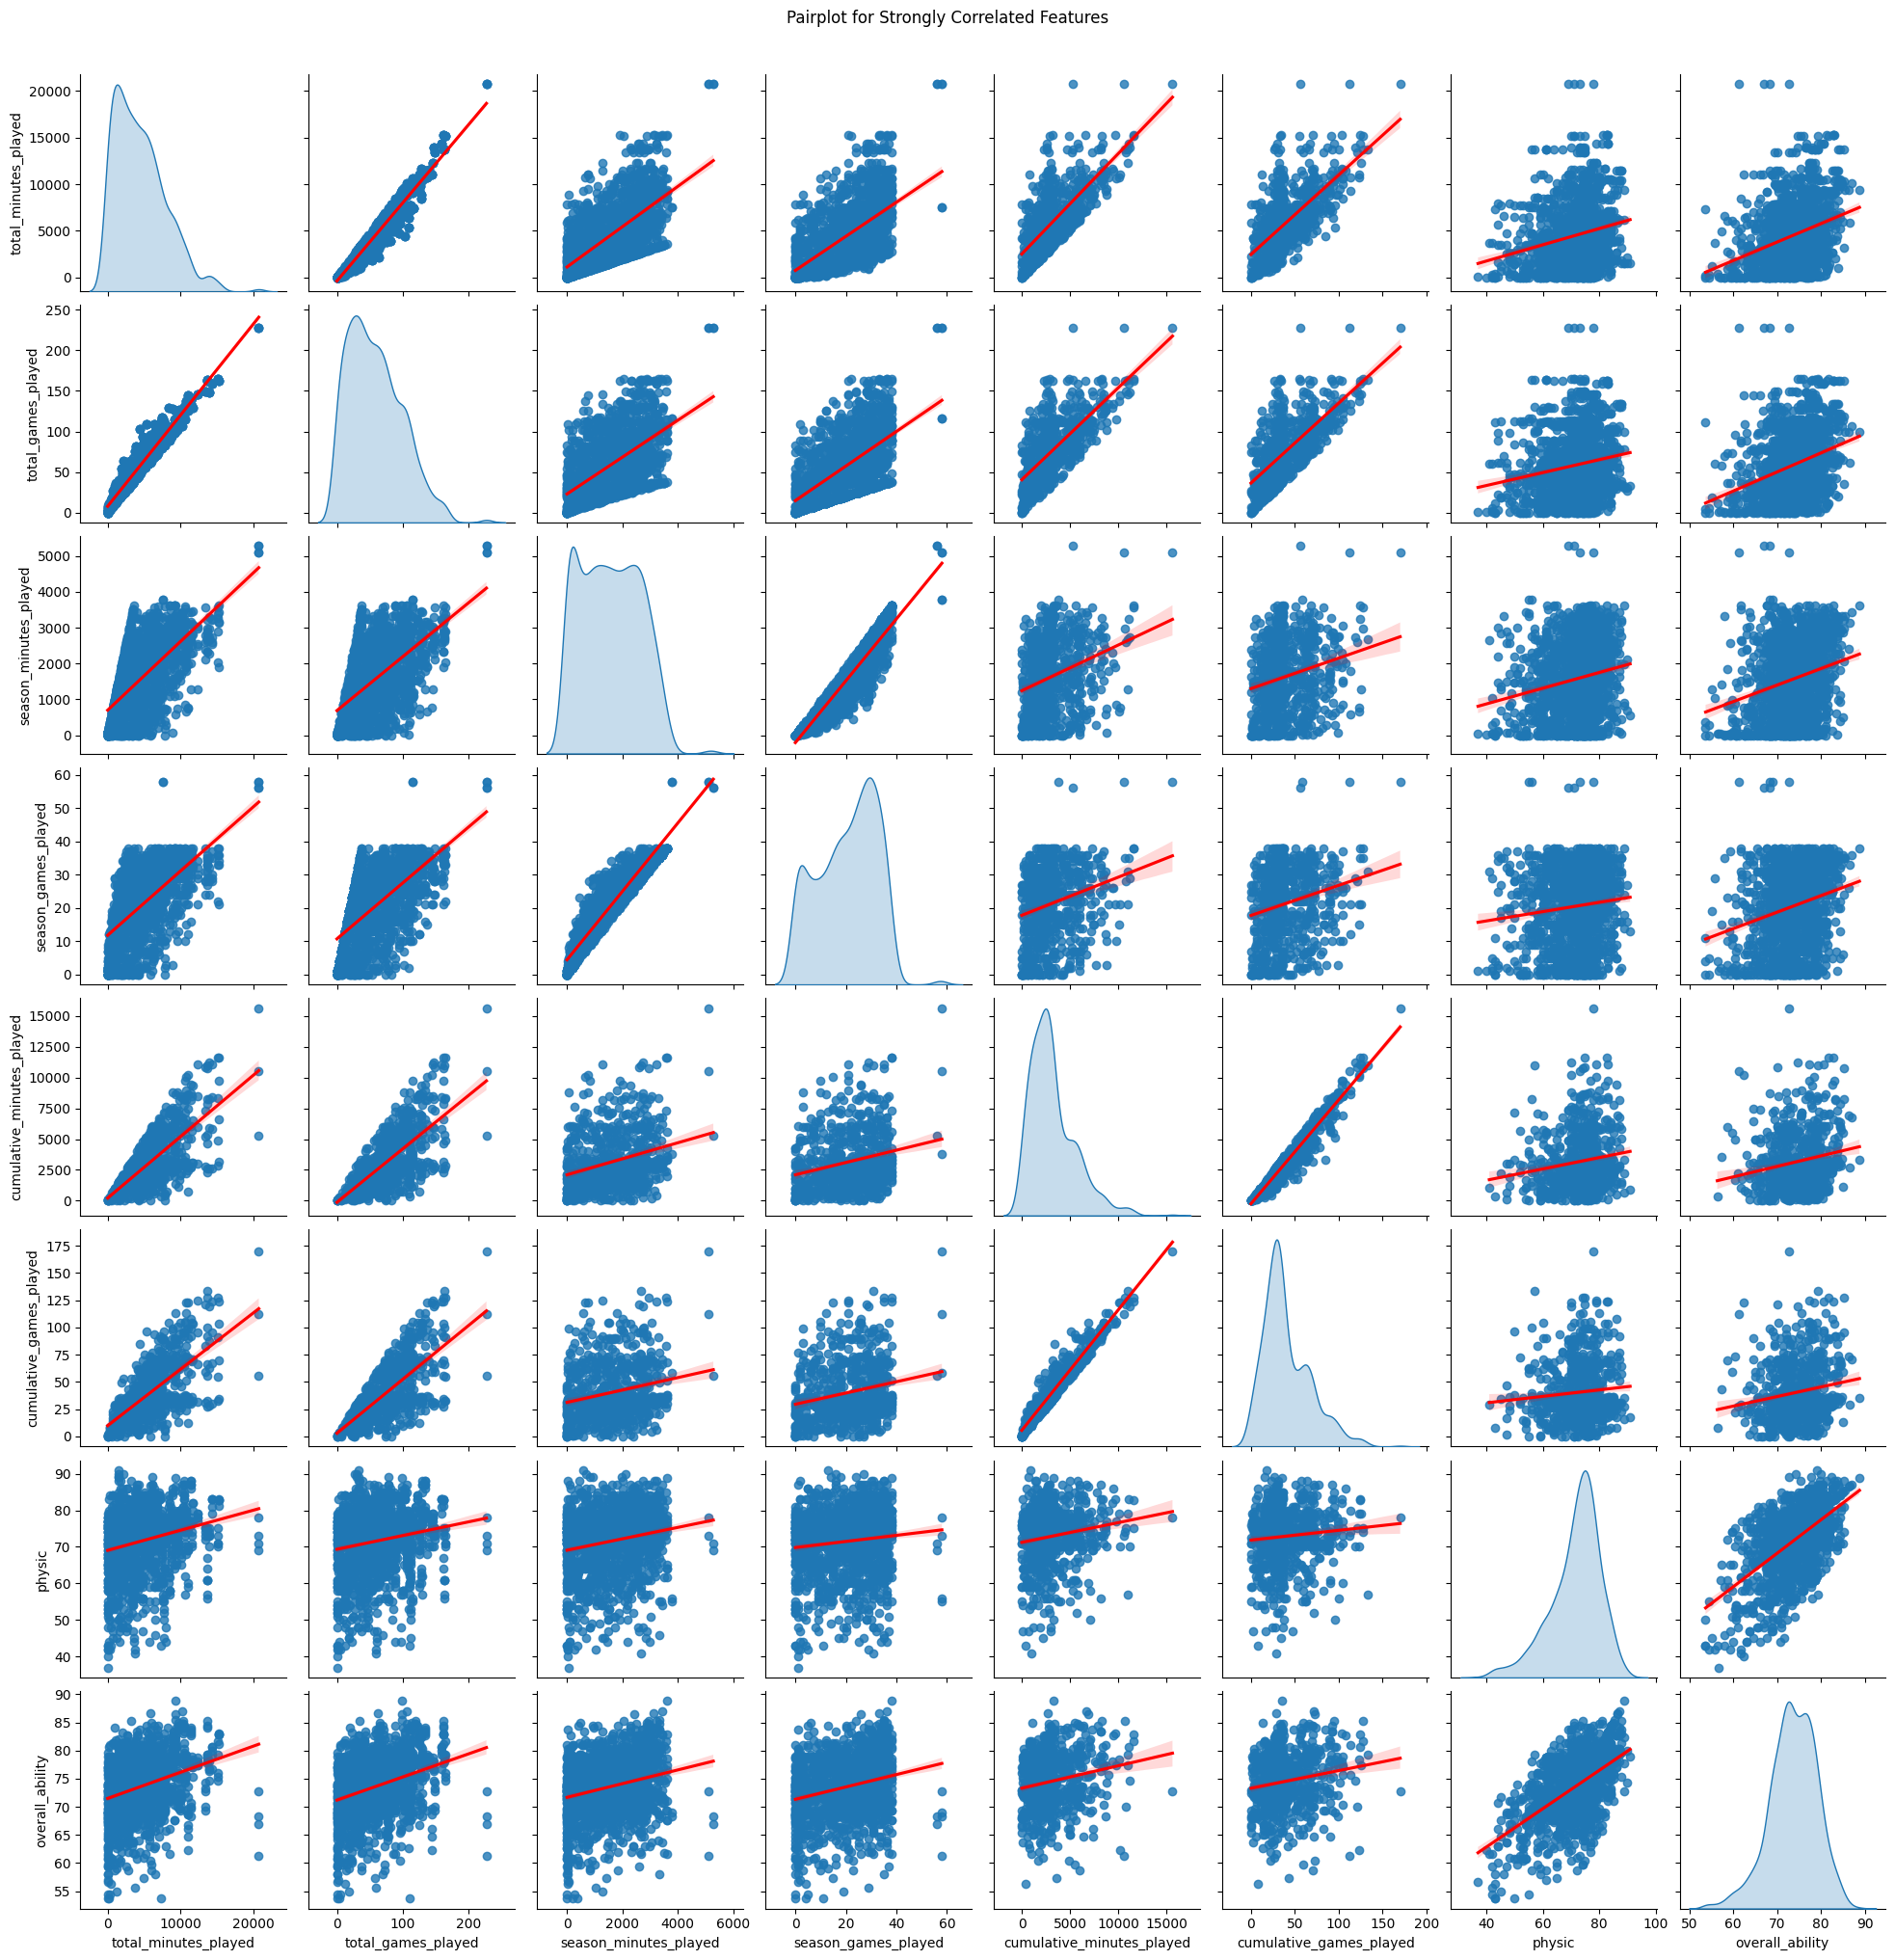

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting features with strong correlations (positive or negative) from the correlation matrix
strong_corr_features = [
    'total_minutes_played', 'total_games_played', 'season_minutes_played', 
    'season_games_played', 'cumulative_minutes_played', 'cumulative_games_played', 
    'physic', 'overall_ability'
]

# Creating a pairplot for these features
sns.pairplot(df_final_player[strong_corr_features], kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}})
plt.suptitle("Pairplot for Strongly Correlated Features", y=1.02)
plt.show()


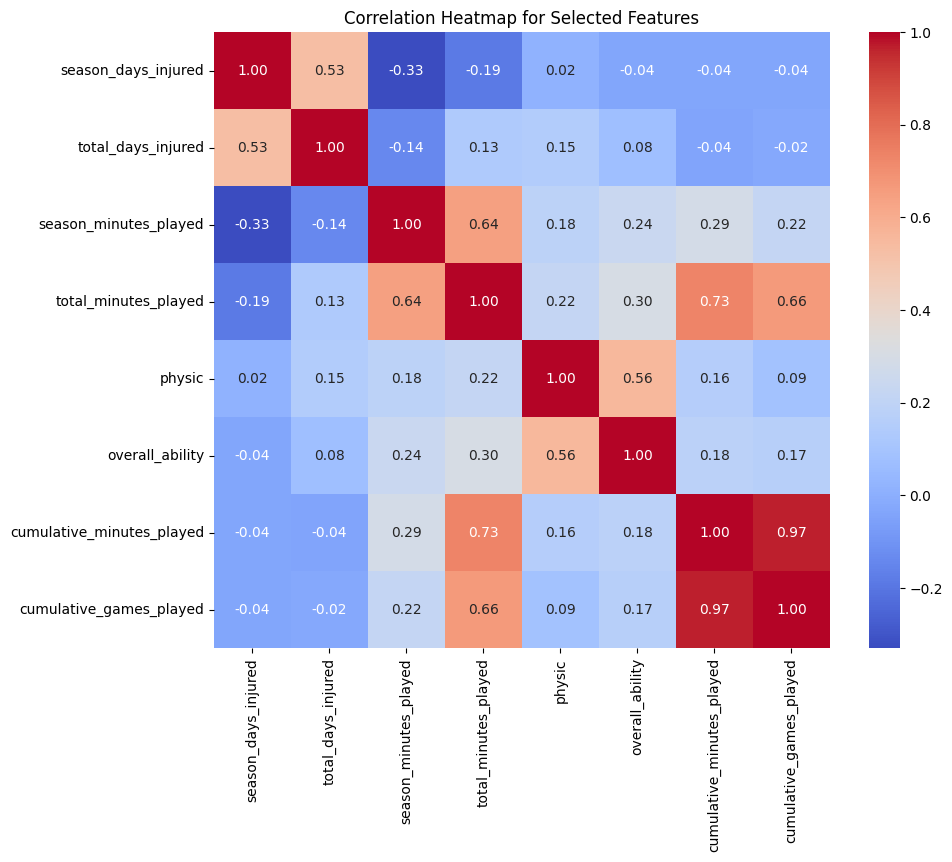

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focus on a subset of features with high correlations
subset_features = [
    'season_days_injured', 'total_days_injured', 'season_minutes_played', 
    'total_minutes_played', 'physic', 'overall_ability', 
    'cumulative_minutes_played', 'cumulative_games_played'
]

# Create a correlation matrix for the subset
subset_corr_matrix = df_final_player[subset_features].corr()

# Plot the heatmap for the subset
plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)
plt.title('Correlation Heatmap for Selected Features')
plt.show()


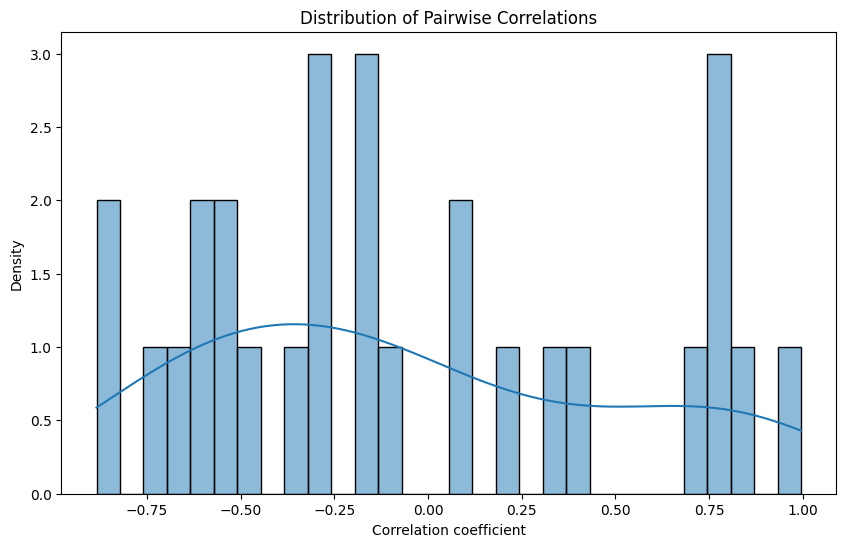

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the upper triangle of the correlation matrix
corr_matrix = subset_corr_matrix.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Flatten the matrix and remove NaNs
corr_values = upper_triangle.stack().reset_index(name='correlation')

# Plot the distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(corr_values['correlation'], kde=True, bins=30)
plt.title('Distribution of Pairwise Correlations')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density')
plt.show()


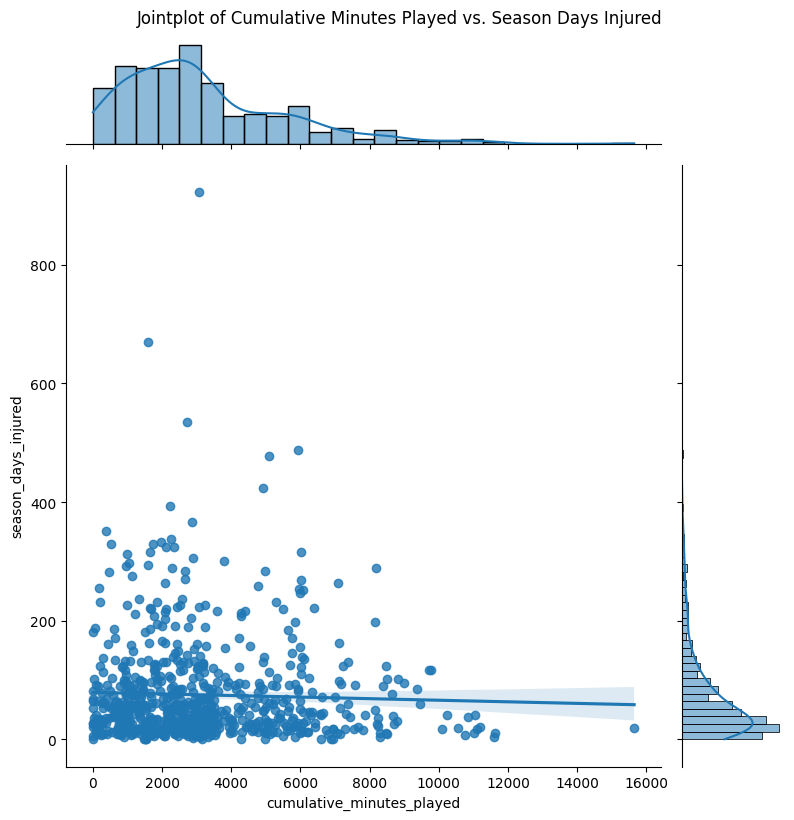

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot jointplot for a feature with high correlation with the target variable
sns.jointplot(x='cumulative_minutes_played', y='season_days_injured', data=df_final_player, kind='reg', height=8)
plt.suptitle('Jointplot of Cumulative Minutes Played vs. Season Days Injured', y=1.02)
plt.show()


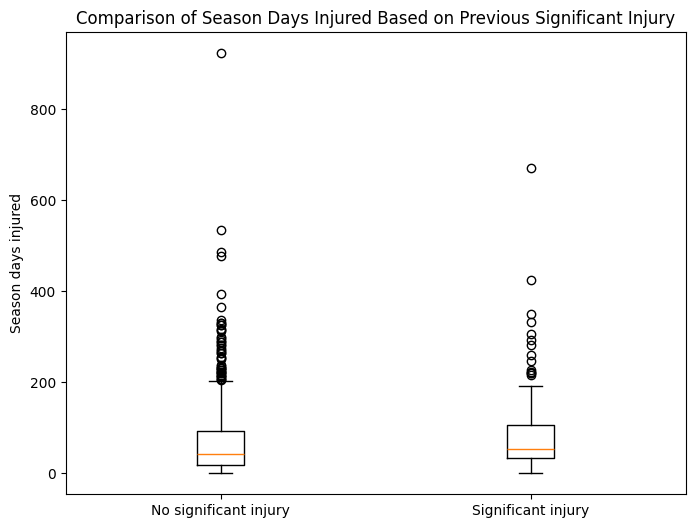

In [45]:
import matplotlib.pyplot as plt

# Drop rows with NaN values to ensure clean data
df_nonulls = df_season.dropna()

# Create a boxplot to compare 'season_days_injured' between players with and without significant injury in the previous season
plt.figure(figsize=(8, 6))
plt.boxplot([df_nonulls.loc[df_nonulls['significant_injury_prev_season'] == 0, 'season_days_injured'], 
             df_nonulls.loc[df_nonulls['significant_injury_prev_season'] == 1, 'season_days_injured']])
plt.xticks([1, 2], ['No significant injury', 'Significant injury'])
plt.ylabel('Season days injured')
plt.title('Comparison of Season Days Injured Based on Previous Significant Injury')
plt.show()




In [46]:
# Count the number of players in each position
position_counts = df_final_player['position'].value_counts()
print("Count of players by position:")
print(position_counts)


Count of players by position:
position
Midfielder    527
Defender      508
Forward       296
Goalkeeper    106
Name: count, dtype: int64


In [47]:
# Check for NaN values in season_days_injured
nan_injured_counts = df_final_player['season_days_injured'].isna().sum()
print(f"Number of NaN values in season_days_injured: {nan_injured_counts}")


Number of NaN values in season_days_injured: 0


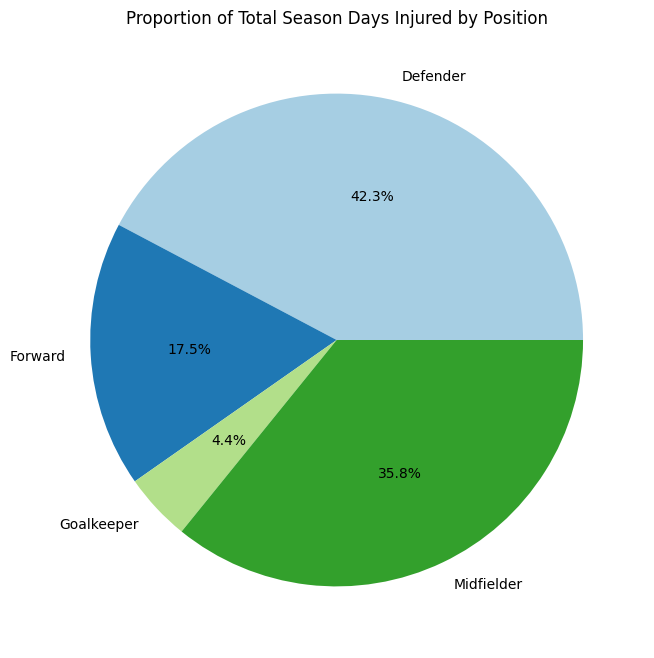

In [48]:
import matplotlib.pyplot as plt

# Extract non-null data
df_nonulls = df_final_player.dropna()

# Calculate total injured days by position
position_totals = df_nonulls.groupby('position')['season_days_injured'].sum()

# Plot pie chart
plt.figure(figsize=(8, 8))
position_totals.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors)

plt.title('Proportion of Total Season Days Injured by Position')
plt.ylabel('')  # Hide y-label
plt.show()




In [49]:
import numpy as np

# Function to Calculate Percentages of Players Above Different Injury Thresholds
def calculate_threshold_percentages(df, column_name, threshold_range):
    """
    This function calculates the percentage of players who exceed various thresholds 
    for a given column, typically 'season_days_injured'. This helps in determining 
    an appropriate threshold to define a 'major injury'.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to analyze (e.g., 'season_days_injured').
    threshold_range (array-like): A range of threshold values to evaluate.

    Returns:
    List: A list of percentages corresponding to each threshold.
    """
    percentages = []
    for threshold in threshold_range:
        # Calculate the percentage of players with injury days above the threshold
        percentage_above_threshold = (df[column_name] > threshold).mean()
        percentages.append(percentage_above_threshold)
    return percentages

# Define the range of thresholds to analyze
threshold_range = np.arange(0, 210, 10)

# Call the function to calculate the percentages for each threshold
percentages = calculate_threshold_percentages(df_final_player, 'season_days_injured', threshold_range)

# Output the results
print("Thresholds vs Percentage of Players with Major Injury:")
for threshold, percentage in zip(threshold_range, percentages):
    print(f'Threshold: {threshold} days - {percentage:.2%} of players exceed this threshold')


Thresholds vs Percentage of Players with Major Injury:
Threshold: 0 days - 99.86% of players exceed this threshold
Threshold: 10 days - 90.54% of players exceed this threshold
Threshold: 20 days - 75.37% of players exceed this threshold
Threshold: 30 days - 64.23% of players exceed this threshold
Threshold: 40 days - 54.28% of players exceed this threshold
Threshold: 50 days - 46.69% of players exceed this threshold
Threshold: 60 days - 39.87% of players exceed this threshold
Threshold: 70 days - 35.14% of players exceed this threshold
Threshold: 80 days - 31.18% of players exceed this threshold
Threshold: 90 days - 26.72% of players exceed this threshold
Threshold: 100 days - 22.76% of players exceed this threshold
Threshold: 110 days - 20.25% of players exceed this threshold
Threshold: 120 days - 18.86% of players exceed this threshold
Threshold: 130 days - 16.14% of players exceed this threshold
Threshold: 140 days - 14.41% of players exceed this threshold
Threshold: 150 days - 13.4

In [50]:
# Define the injury threshold (this should be decided based on the analysis above)
injury_threshold = 120  # Example threshold, adjust as needed based on previous analysis

# Create a new target variable 'target_major_injury'
# This variable will be 1 if 'season_days_injured' exceeds the injury_threshold (indicating a major injury)
# and 0 otherwise (indicating a minor or no injury)
df_final_player['target_major_injury'] = (df_final_player['season_days_injured'] > injury_threshold).astype('category')

# Display the distribution of the target variable
# This shows how many players had major injuries (1) versus minor or no injuries (0)
print("Distribution of Target Variable 'target_major_injury':")
print(df_final_player['target_major_injury'].value_counts())


Distribution of Target Variable 'target_major_injury':
target_major_injury
False    1166
True      271
Name: count, dtype: int64


Distribution of Target Variable 'target_major_injury':
target_major_injury
False    1166
True      271
Name: count, dtype: int64


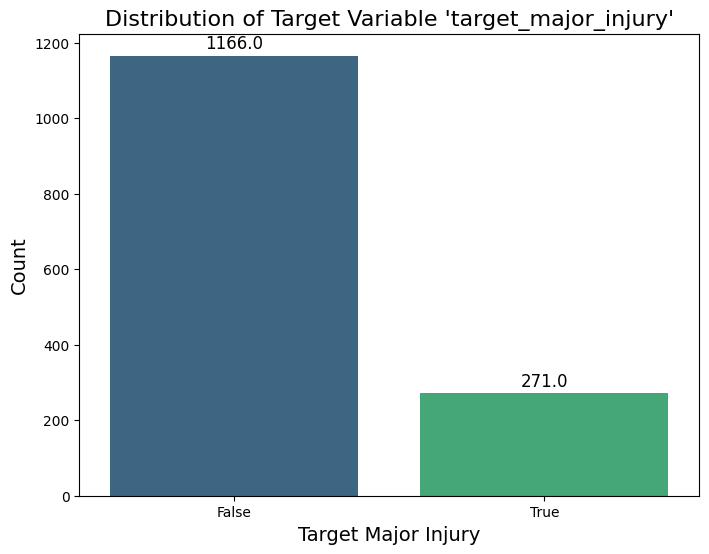

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print the value counts for the target variable
print("Distribution of Target Variable 'target_major_injury':")
print(df_final_player['target_major_injury'].value_counts())

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target_major_injury', data=df_final_player, hue='target_major_injury', palette='viridis', legend=False)

# Adding annotations to the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

# Title and labels
plt.title("Distribution of Target Variable 'target_major_injury'", fontsize=16)
plt.xlabel('Target Major Injury', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()


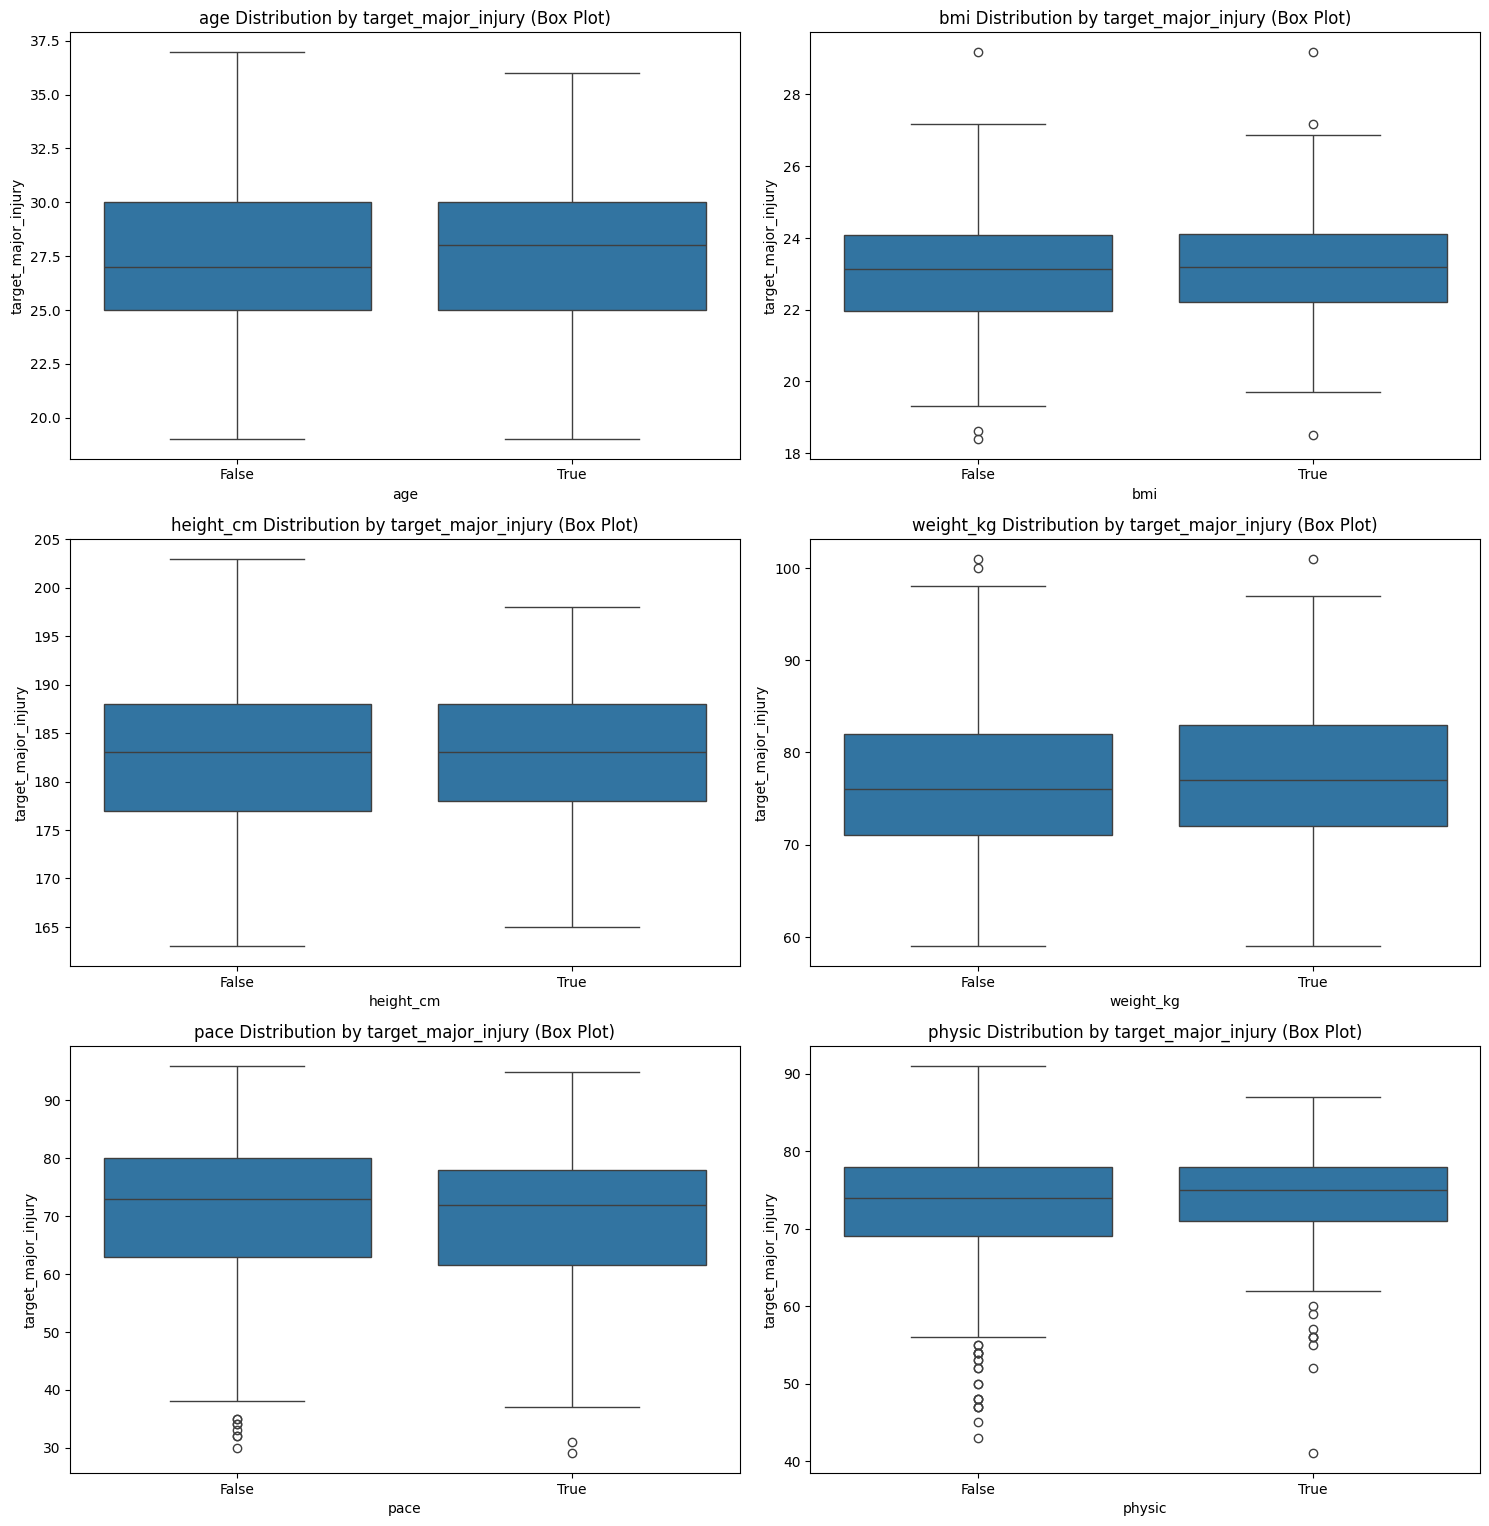

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot features vs. binary target using appropriate graphs
def plot_features_vs_binary_target(df, x_features, y_feature):
    df_nonulls = df.dropna()

    plt.figure(figsize=(15, 20))

    for i, column in enumerate(x_features, 1):
        plt.subplot(4, 2, i)

        # Use count plot for binary target
        if df_nonulls[column].nunique() <= 2:
            sns.countplot(x=column, hue=y_feature, data=df_nonulls, ax=plt.gca())
            plt.title(f'{column} Count by {y_feature}')
        
        # Use box plot for continuous features
        elif df_nonulls[column].nunique() > 2:
            sns.boxplot(x=y_feature, y=column, data=df_nonulls, ax=plt.gca())
            plt.title(f'{column} Distribution by {y_feature} (Box Plot)')
        
        # Optionally, use violin plot for more detailed distribution
        else:
            sns.violinplot(x=y_feature, y=column, data=df_nonulls, ax=plt.gca(), inner="quartile")
            plt.title(f'{column} Distribution by {y_feature} (Violin Plot)')
        
        plt.xlabel(column)
        plt.ylabel(y_feature)

    plt.tight_layout()
    plt.show()

    # Define the physical features to plot
physical_features = ['age', 'bmi', 'height_cm', 'weight_kg', 'pace', 'physic']

# Call the function to plot the features against the binary target variable
plot_features_vs_binary_target(df_final_player, physical_features, 'target_major_injury')


In [53]:
df_final_player_data = df_final_player

In [54]:
import pandas as pd

# Basic information about the dataset
print(df_final_player_data.info())

# Summary statistics
print(df_final_player_data.describe())

# Check for missing values
print(df_final_player_data.isnull().sum())
print(df_final_player_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   player_id                          1437 non-null   object  
 1   start_year                         1437 non-null   int64   
 2   season_days_injured                1437 non-null   int64   
 3   total_days_injured                 1437 non-null   int64   
 4   season_minutes_played              1437 non-null   float64 
 5   total_minutes_played               1437 non-null   float64 
 6   season_games_played                1437 non-null   int64   
 7   total_games_played                 1437 non-null   int64   
 8   season_matches_in_squad            1437 non-null   int64   
 9   height_cm                          1437 non-null   float64 
 10  weight_kg                          1437 non-null   float64 
 11  nationality                        1437 non

In [55]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Checkpoint 1: Verify initial missing values
print("Initial missing values in each column:\n", df_final_player_data.isnull().sum())

# Imputing numerical columns with mean
mean_imputer = SimpleImputer(strategy='mean')
numerical_columns = ['cumulative_minutes_played', 'minutes_per_game_prev_seasons', 'avg_days_injured_prev_seasons',
                     'cumulative_games_played', 'avg_games_per_season_prev_seasons', 'cumulative_days_injured']
df_final_player[numerical_columns] = mean_imputer.fit_transform(df_final_player_data[numerical_columns])

# Imputing categorical columns with mode
mode_imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = ['significant_injury_prev_season', 'season_days_injured_prev_season']
df_final_player_data[categorical_columns] = mode_imputer.fit_transform(df_final_player_data[categorical_columns])

# Checkpoint 2: Verify missing values after imputation
print("Missing values after imputation:\n", df_final_player_data.isnull().sum())


Initial missing values in each column:
 player_id                              0
start_year                             0
season_days_injured                    0
total_days_injured                     0
season_minutes_played                  0
total_minutes_played                   0
season_games_played                    0
total_games_played                     0
season_matches_in_squad                0
height_cm                              0
weight_kg                              0
nationality                            0
work_rate                              0
pace                                   0
physic                                 0
fifa_rating                            0
position                               0
overall_ability                        0
age                                    0
experience                             0
cumulative_minutes_played            723
cumulative_games_played              723
minutes_per_game_prev_seasons        731
avg_days_injured_

In [56]:
# Interaction Terms
df_final_player_data['age_x_minutes_played'] = df_final_player_data['age'] * df_final_player_data['cumulative_minutes_played']
df_final_player_data['pace_x_physic'] = df_final_player_data['pace'] * df_final_player_data['physic']

# Temporal Features
df_final_player_data['rolling_avg_minutes_per_game'] = df_final_player_data.groupby('player_id')['minutes_per_game_prev_seasons'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Non-Linear Transformations
df_final_player_data['log_weight'] = np.log(df_final_player_data['weight_kg'] + 1)
df_final_player_data['sqrt_pace'] = np.sqrt(df_final_player_data['pace'])

# Checkpoint 3: Verify new features
print("New features added:\n", df_final_player_data[['age_x_minutes_played', 'pace_x_physic', 'rolling_avg_minutes_per_game', 'log_weight', 'sqrt_pace']].head())


New features added:
    age_x_minutes_played  pace_x_physic  rolling_avg_minutes_per_game  \
0          79379.481793         6586.0                     75.093947   
1          34944.000000         6512.0                     79.546974   
2          82554.661064         6320.0                     75.093947   
3          38934.000000         6162.0                     68.894800   
4          82554.661064         6188.0                     75.093947   

   log_weight  sqrt_pace  
0    4.189655   9.433981  
1    4.189655   9.380832  
2    4.369448   8.944272  
3    4.369448   8.831761  
4    4.304065   9.539392  


In [57]:
# Encoding categorical features
df_final_player_data = pd.get_dummies(df_final_player_data, columns=['nationality', 'work_rate', 'position'], drop_first=True)

# Checkpoint 4: Verify categorical encoding
print("Columns after encoding categorical features:\n", df_final_player_data.columns)


Columns after encoding categorical features:
 Index(['player_id', 'start_year', 'season_days_injured', 'total_days_injured',
       'season_minutes_played', 'total_minutes_played', 'season_games_played',
       'total_games_played', 'season_matches_in_squad', 'height_cm',
       ...
       'work_rate_High/Medium', 'work_rate_Low/High', 'work_rate_Low/Low',
       'work_rate_Low/Medium', 'work_rate_Medium/High', 'work_rate_Medium/Low',
       'work_rate_Medium/Medium', 'position_Forward', 'position_Goalkeeper',
       'position_Midfielder'],
      dtype='object', length=111)


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df_final_player_data is your DataFrame after feature engineering
# Prepare the features and target variable
X = df_final_player_data.drop(columns=['target_major_injury','player_id'])
y = df_final_player_data['target_major_injury']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest to get feature importances
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Select features based on importance
selector = SelectFromModel(rf_clf, threshold="median")
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Print the selected features
selected_features = X.columns[selector.get_support()]
print("Selected features based on Random Forest importance:\n", selected_features)


Selected features based on Random Forest importance:
 Index(['start_year', 'season_days_injured', 'total_days_injured',
       'season_minutes_played', 'total_minutes_played', 'season_games_played',
       'total_games_played', 'season_matches_in_squad', 'height_cm',
       'weight_kg', 'pace', 'physic', 'fifa_rating', 'overall_ability', 'age',
       'experience', 'cumulative_minutes_played', 'cumulative_games_played',
       'minutes_per_game_prev_seasons', 'avg_days_injured_prev_seasons',
       'avg_games_per_season_prev_seasons', 'bmi',
       'significant_injury_prev_season', 'cumulative_days_injured',
       'season_days_injured_prev_season', 'age_x_minutes_played',
       'pace_x_physic', 'rolling_avg_minutes_per_game', 'log_weight',
       'sqrt_pace', 'nationality_Argentina', 'nationality_Belgium',
       'nationality_Bosnia Herzegovina', 'nationality_Brazil',
       'nationality_England', 'nationality_France', 'nationality_Germany',
       'nationality_Italy', 'nationality_M

Correlation with target variable:
 target_major_injury        1.000000
season_days_injured        0.790235
total_days_injured         0.413959
cumulative_days_injured    0.210152
nationality_Argentina      0.064679
                             ...   
total_games_played        -0.164465
total_minutes_played      -0.166186
season_minutes_played     -0.298236
season_games_played       -0.326996
season_matches_in_squad   -0.408805
Name: target_major_injury, Length: 110, dtype: float64


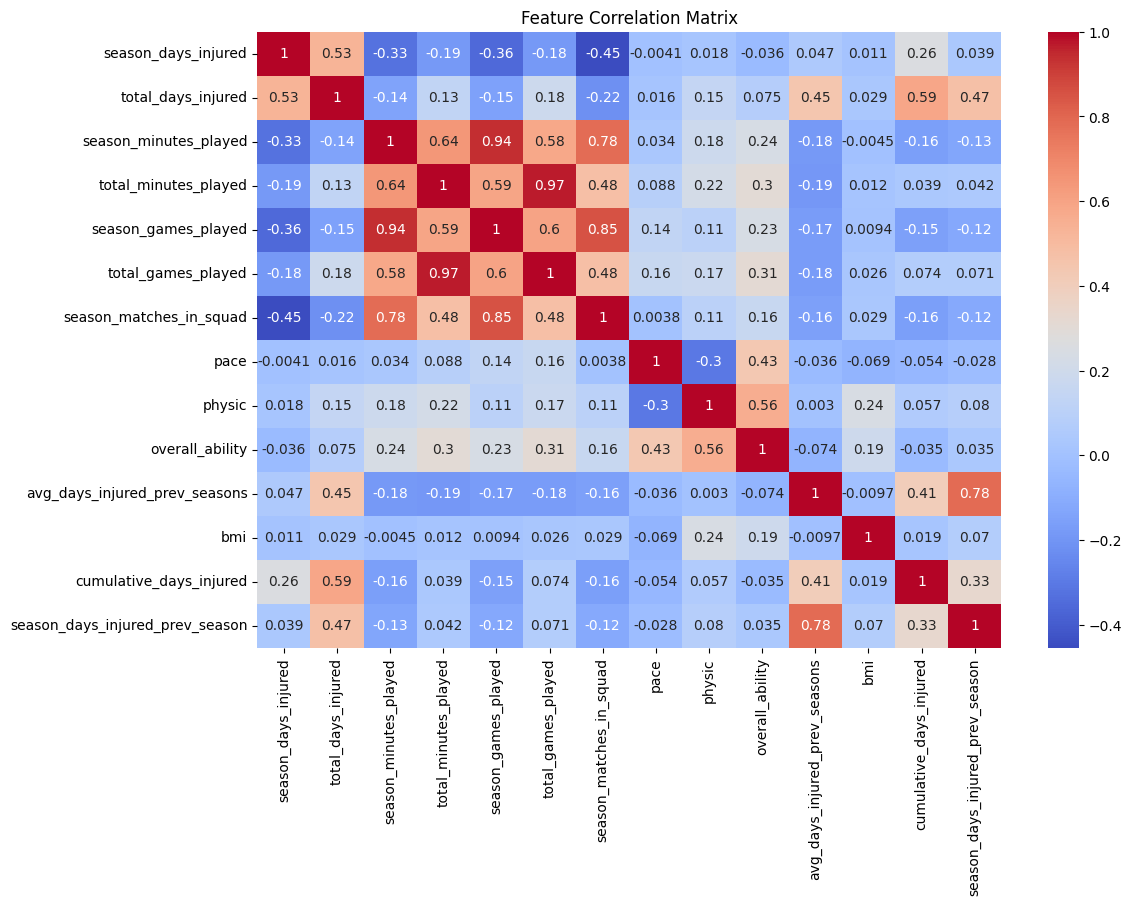

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_final_player_data = df_final_player_data.drop(columns=['player_id'])
# Check the correlation of each feature with the target
correlation_with_target = df_final_player_data.corr()['target_major_injury'].sort_values(ascending=False)
print("Correlation with target variable:\n", correlation_with_target)

# Plot correlation matrix to check for multicollinearity
plt.figure(figsize=(12, 8))
sns.heatmap(df_final_player_data[['season_days_injured', 'total_days_injured', 'season_minutes_played',
                                  'total_minutes_played', 'season_games_played', 'total_games_played',
                                  'season_matches_in_squad', 'pace', 'physic', 'overall_ability',
                                  'avg_days_injured_prev_seasons', 'bmi', 'cumulative_days_injured',
                                  'season_days_injured_prev_season']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



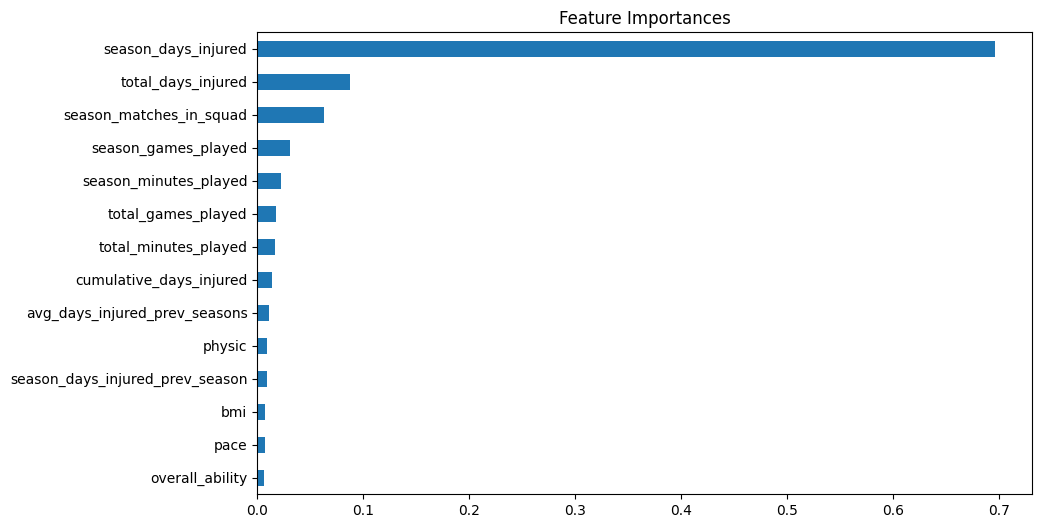

In [60]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier

X = df_final_player_data[['season_days_injured', 'total_days_injured', 'season_minutes_played',
                          'total_minutes_played', 'season_games_played', 'total_games_played',
                          'season_matches_in_squad', 'pace', 'physic', 'overall_ability',
                          'avg_days_injured_prev_seasons', 'bmi', 'cumulative_days_injured',
                          'season_days_injured_prev_season']]
y = df_final_player_data['target_major_injury']

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X, y)

# Get feature importances
importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importances', figsize=(10, 6))
plt.show()


In [61]:
# Drop the less relevant features and those that are highly correlated (containing the same information) based on the decision.
df_final_player_data_reduced = df_final_player_data.drop(columns=['total_minutes_played', 'total_days_injured','total_games_played','age_x_minutes_played', 'avg_days_injured_prev_seasons', 
                                                                          'rolling_avg_minutes_per_game', 'log_weight', 'sqrt_pace','cumulative_games_played'])

# Display remaining columns
print("Remaining columns after dropping less relevant features:")
print(df_final_player_data_reduced.columns)


Remaining columns after dropping less relevant features:
Index(['start_year', 'season_days_injured', 'season_minutes_played',
       'season_games_played', 'season_matches_in_squad', 'height_cm',
       'weight_kg', 'pace', 'physic', 'fifa_rating',
       ...
       'work_rate_High/Medium', 'work_rate_Low/High', 'work_rate_Low/Low',
       'work_rate_Low/Medium', 'work_rate_Medium/High', 'work_rate_Medium/Low',
       'work_rate_Medium/Medium', 'position_Forward', 'position_Goalkeeper',
       'position_Midfielder'],
      dtype='object', length=101)


In [62]:
# Final Checkpoint: Verify the entire dataset structure after preprocessing
print("Final dataset structure:\n", df_final_player_data_reduced.info())
print("Sample of the final dataset:\n", df_final_player_data_reduced.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Columns: 101 entries, start_year to position_Midfielder
dtypes: bool(79), category(1), float64(15), int64(6)
memory usage: 348.2 KB
Final dataset structure:
 None
Sample of the final dataset:
    start_year  season_days_injured  season_minutes_played  \
0        2017                   50                 1344.0   
1        2018                   16                  160.0   
2        2017                    8                 1442.0   
3        2018                   97                  856.0   
4        2017                   12                 1631.0   

   season_games_played  season_matches_in_squad  height_cm  weight_kg  pace  \
0                   16                       24      171.0       65.0  89.0   
1                    2                       18      171.0       65.0  88.0   
2                   23                       36      184.0       78.0  80.0   
3                   11                       26   

In [63]:
from sklearn.preprocessing import StandardScaler

# Assuming you have separated your target variable
X = df_final_player_data_reduced.drop(columns=['target_major_injury'])
y = df_final_player_data_reduced['target_major_injury']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the feature set
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for easier manipulation later
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Check the first few rows of the scaled data
print(X_scaled_df.head())


   start_year  season_days_injured  season_minutes_played  \
0   -0.835957            -0.292955              -0.208682   
1   -0.103475            -0.683781              -1.335412   
2   -0.835957            -0.775740              -0.115422   
3   -0.103475             0.247304              -0.673077   
4   -0.835957            -0.729760               0.064436   

   season_games_played  season_matches_in_squad  height_cm  weight_kg  \
0            -0.393728                -0.150277  -1.627676  -1.474276   
1            -1.614975                -0.726140  -1.627676  -1.474276   
2             0.216896                 1.001447   0.231828   0.194974   
3            -0.829887                 0.041677   0.231828   0.194974   
4             0.565824                 0.521562  -0.340327  -0.447045   

       pace    physic  fifa_rating  ...  work_rate_High/Medium  \
0  1.405185  0.279134     0.109789  ...              -0.616769   
1  1.327155  0.279134    -0.051857  ...              -0.616769

In [64]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Step 1: Train a RandomForest to get feature importances
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_scaled_df, y)

# Step 2: Get the feature importances
feature_importances = rf_clf.feature_importances_

# Step 3: Create a DataFrame for better visualization of the feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': feature_importances
})

# Step 4: Sort features by importance
feature_ranking = feature_ranking.sort_values(by='Importance', ascending=False)

# Step 5: Print the feature ranking
print("Feature ranking based on importance:\n", feature_ranking)

# After verifying the output, proceed to the next step for feature selection


Feature ranking based on importance:
                      Feature  Importance
1        season_days_injured    0.602329
4    season_matches_in_squad    0.078748
3        season_games_played    0.039584
2      season_minutes_played    0.028888
18   cumulative_days_injured    0.021265
..                       ...         ...
54        nationality_Israel    0.000000
32        nationality_Canada    0.000000
60        nationality_Mexico    0.000000
30  nationality_Burkina Faso    0.000000
26         nationality_Benin    0.000000

[100 rows x 2 columns]


In [65]:
# Step 5: Print the top 15 features based on their ranking
top_15_features = feature_ranking.head(15)
print("Top 15 features based on importance:\n", top_15_features)


Top 15 features based on importance:
                               Feature  Importance
1                 season_days_injured    0.602329
4             season_matches_in_squad    0.078748
3                 season_games_played    0.039584
2               season_minutes_played    0.028888
18            cumulative_days_injured    0.021265
10                    overall_ability    0.016425
20                      pace_x_physic    0.015658
8                              physic    0.014553
16                                bmi    0.014543
7                                pace    0.014325
9                         fifa_rating    0.014057
5                           height_cm    0.013601
6                           weight_kg    0.011924
15  avg_games_per_season_prev_seasons    0.011869
11                                age    0.011175


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Assuming X_scaled_df is your scaled training data and y is your target

# Train a RandomForest to get feature importances
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_scaled_df, y)

# Sort features by importance and select the top 10
feature_importances = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances['Feature'].head(10).values

# Select only the top 10 features from X_scaled_df
X_selected_df = X_scaled_df[top_10_features]

# Print the selected features
print("Selected top 10features based on importance:\n", X_selected_df.columns)
print("Shape of X_selected_df:", X_selected_df.shape)


Selected top 10features based on importance:
 Index(['season_days_injured', 'season_matches_in_squad', 'season_games_played',
       'season_minutes_played', 'cumulative_days_injured', 'overall_ability',
       'pace_x_physic', 'physic', 'bmi', 'pace'],
      dtype='object')
Shape of X_selected_df: (1437, 10)


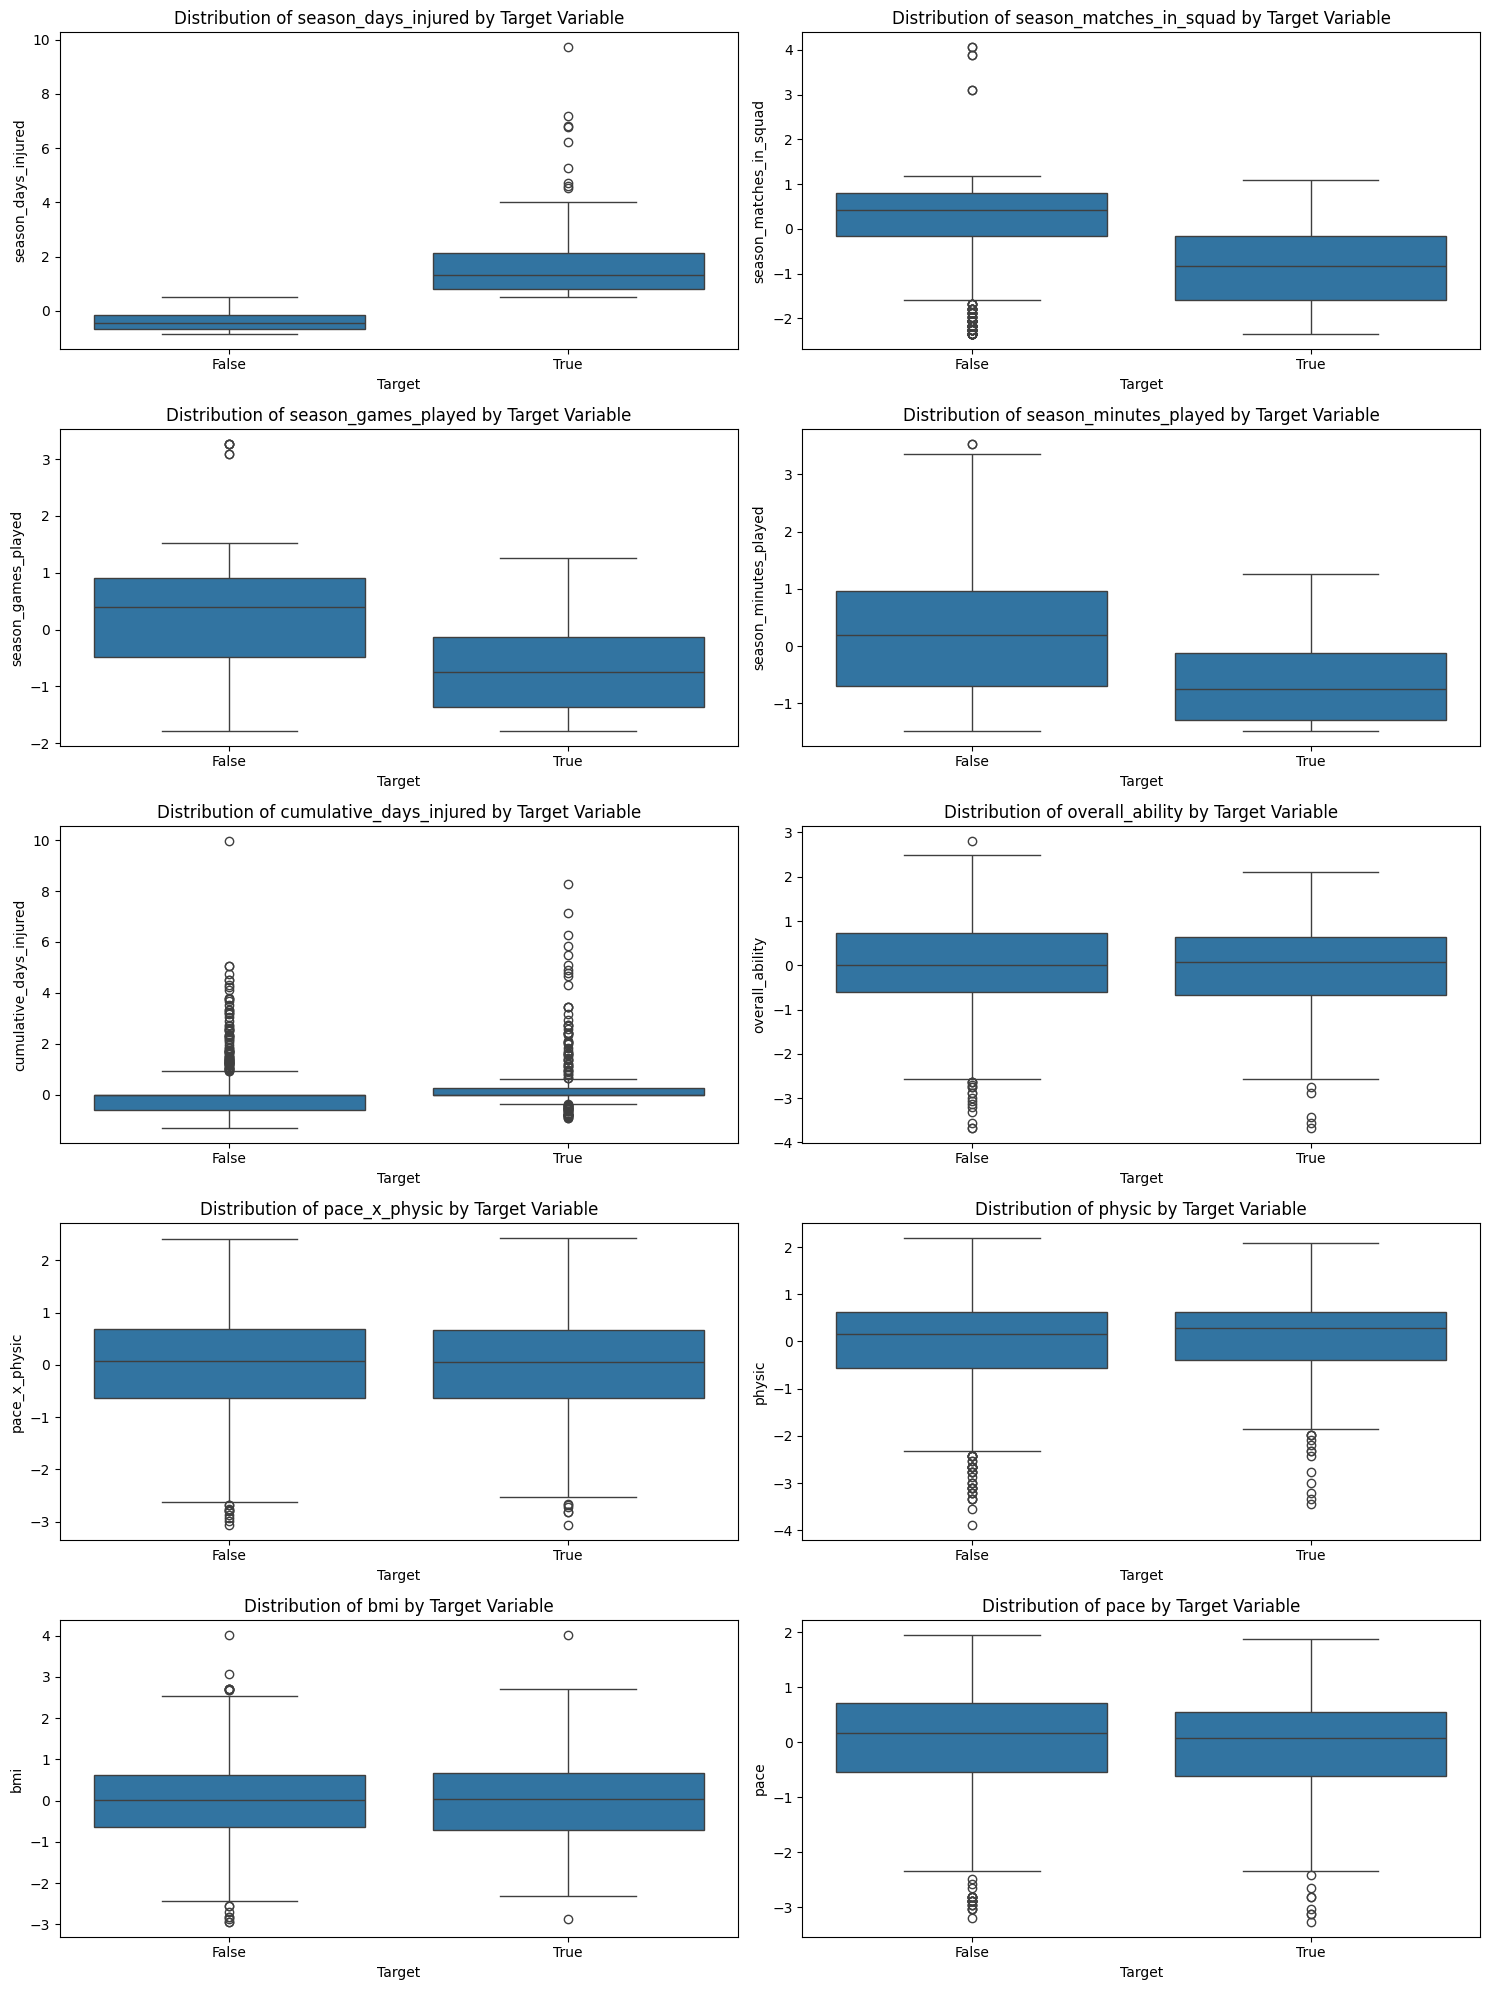

In [67]:
# Plot the graphs for the top 10 important features against the binary target variable
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(top_10_features):
    sns.boxplot(x=y, y=X_selected_df[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Target Variable')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


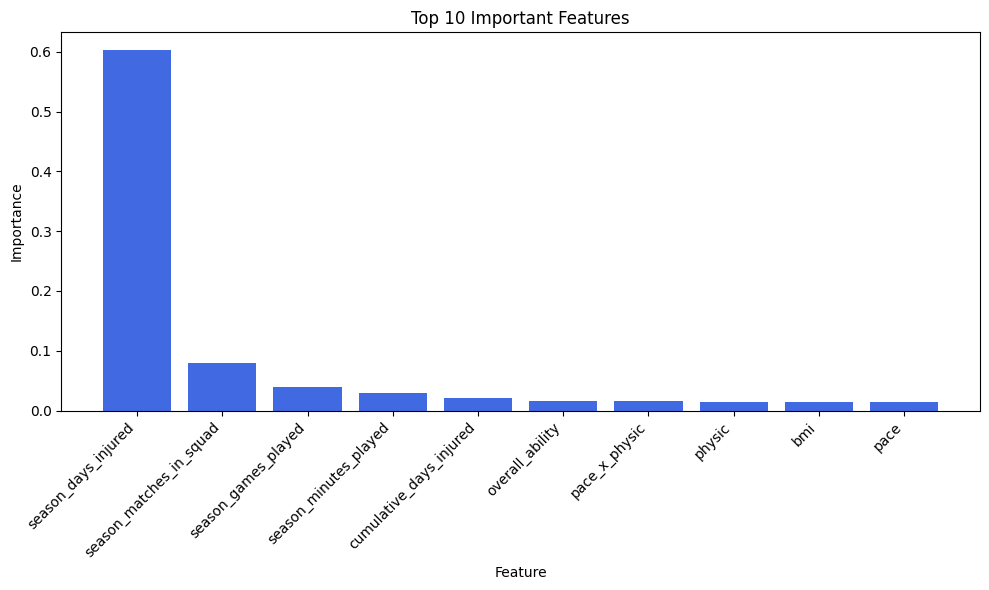

In [68]:
import matplotlib.pyplot as plt

# Assuming 'feature_importances' DataFrame is already defined as in your code
# Select the top 10 features based on importance
top_10_features = feature_importances.head(10)

# Plotting the vertical bar graph
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'], color='royalblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Important Features')
plt.xticks(rotation=45, ha='right')  # Rotate the feature names for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()


In [69]:
print("Data type of y_train:", y.dtype)


Data type of y_train: category


In [70]:
# Convert y_train from category to int
y = y.astype(int)


In [71]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=42)

# Step 1: Re-run SMOTE after confirming y_train is correct
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Debugging step: Check the first few rows and unique values of y_train_balanced
print("Unique values in y_train_balanced:", pd.Series(y_train_balanced).unique())
print("First few rows of y_train_balanced:", pd.Series(y_train_balanced).head())

# Check for NaN values after resampling
print("NaN values in y_train_balanced after resampling:", pd.Series(y_train_balanced).isnull().sum())



Unique values in y_train_balanced: [1 0]
First few rows of y_train_balanced: 0    1
1    0
2    0
3    0
4    0
Name: target_major_injury, dtype: int64
NaN values in y_train_balanced after resampling: 0


In [72]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validated AUC-ROC score on training data
    auc_roc_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    # Fit model and predict on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics on the test data
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc_test = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    return accuracy, precision, recall, f1, auc_roc_cv, auc_roc_test

# Initialize models

rf_model = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)
svm_model = SVC(C=0.005, kernel='rbf', class_weight='balanced', probability=True, random_state=42)
xgb_model = XGBClassifier(max_depth=3, n_estimators=200,  reg_alpha=1, reg_lambda=10, scale_pos_weight=7, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Evaluate models using the balanced training data and the unbalanced test data
svm_results = evaluate_model(svm_model, X_train_balanced, y_train_balanced, X_test, y_test)
rf_results = evaluate_model(rf_model, X_train_balanced, y_train_balanced, X_test, y_test)
xgb_results = evaluate_model(xgb_model, X_train_balanced, y_train_balanced, X_test, y_test)
knn_results = evaluate_model(knn_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Create a comparison table
comparison_table = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'KNN', 'XGBoost'],
    'Accuracy': [svm_results[0], rf_results[0], knn_results[0], xgb_results[0]],
    'Precision': [svm_results[1], rf_results[1], knn_results[1], xgb_results[1]],
    'Recall': [svm_results[2], rf_results[2], knn_results[2], xgb_results[2]],
    'F1 Score': [svm_results[3], rf_results[3], knn_results[3], xgb_results[3]],
    'AUC-ROC (CV)': [svm_results[4], rf_results[4], knn_results[4], xgb_results[4]],
    'AUC-ROC (Test)': [svm_results[5], rf_results[5], knn_results[5], xgb_results[5]]
})

# Print the comparison table
print("Final Model Comparison Table:")
print(comparison_table)

# Optionally, save the comparison table to a CSV file
comparison_table.to_csv("model_comparison.csv", index=False)


Final Model Comparison Table:
           Model  Accuracy  Precision    Recall  F1 Score  AUC-ROC (CV)  \
0            SVM  0.871528   0.541667  0.906977  0.678261      0.940713   
1  Random Forest  0.996528   0.977273  1.000000  0.988506      0.999858   
2            KNN  0.937500   0.719298  0.953488  0.820000      0.994557   
3        XGBoost  1.000000   1.000000  1.000000  1.000000      1.000000   

   AUC-ROC (Test)  
0        0.957380  
1        1.000000  
2        0.973469  
3        1.000000  


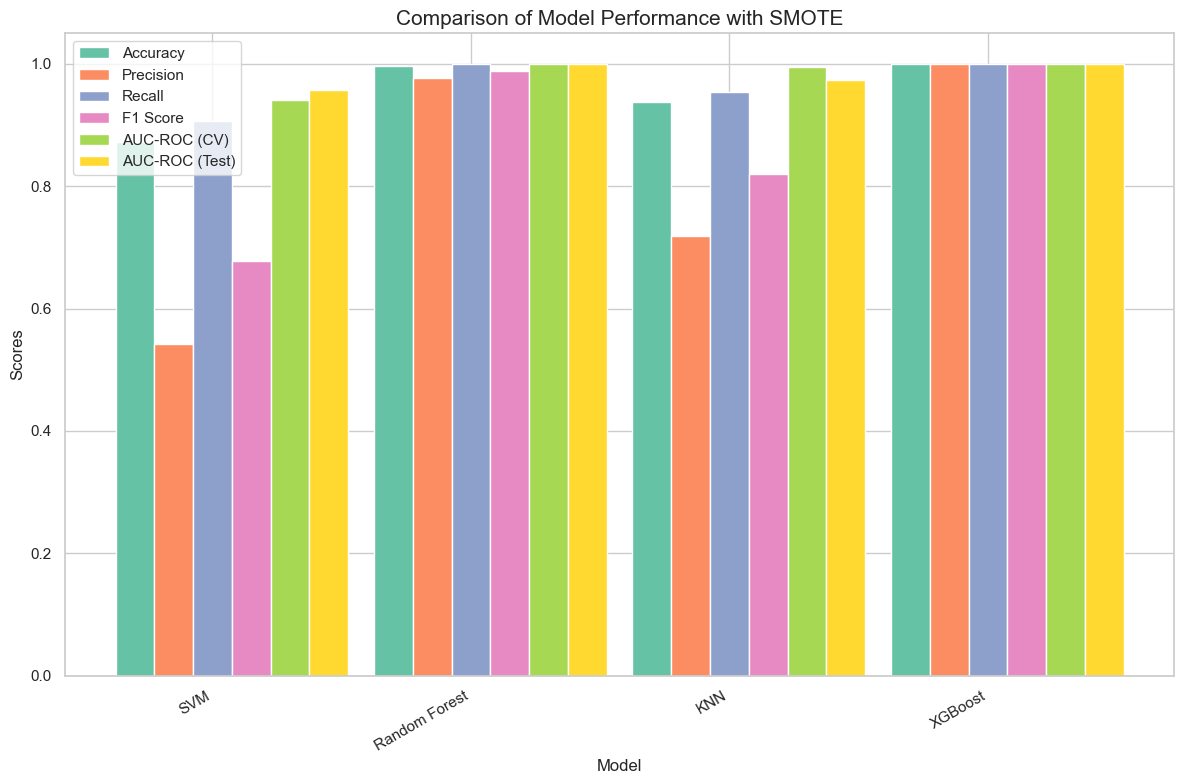

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette for the plot
sns.set(style="whitegrid")
colors = sns.color_palette("Set2", 6)

# Set the figure size
plt.figure(figsize=(12, 8))

# Define the positions of the bars on the x-axis
bar_width = 0.15
index = range(len(comparison_table))

# Plot bars for each metric using the refined color palette
plt.bar(index, comparison_table['Accuracy'], bar_width, label='Accuracy', color=colors[0])
plt.bar([i + bar_width for i in index], comparison_table['Precision'], bar_width, label='Precision', color=colors[1])
plt.bar([i + 2 * bar_width for i in index], comparison_table['Recall'], bar_width, label='Recall', color=colors[2])
plt.bar([i + 3 * bar_width for i in index], comparison_table['F1 Score'], bar_width, label='F1 Score', color=colors[3])
plt.bar([i + 4 * bar_width for i in index], comparison_table['AUC-ROC (CV)'], bar_width, label='AUC-ROC (CV)', color=colors[4])
plt.bar([i + 5 * bar_width for i in index], comparison_table['AUC-ROC (Test)'], bar_width, label='AUC-ROC (Test)', color=colors[5])

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Comparison of Model Performance with SMOTE', fontsize=15)
plt.xticks([i + 2 * bar_width for i in index], comparison_table['Model'], rotation=30, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [74]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=42)

# Step 2: Apply different sampling techniques
# Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Tomek Links
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Evaluate with the previous models
sampling_methods = {
    'Random Undersampling': (X_train_under, y_train_under),
    'Tomek Links': (X_train_tomek, y_train_tomek),
    'SMOTEENN': (X_train_smoteenn, y_train_smoteenn),
}

# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validated AUC-ROC score on training data
    auc_roc_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    # Fit model and predict on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics on the test data
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc_test = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    return accuracy, precision, recall, f1, auc_roc_cv, auc_roc_test

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_split=20, min_samples_leaf=10, class_weight='balanced', random_state=42),
    'SVM': SVC(C=0.007, kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'XGBoost': XGBClassifier(max_depth=3, n_estimators=100, reg_alpha=5, reg_lambda=15, scale_pos_weight=7, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance')
}


# Step 3: Evaluate models using SMOTEENN sampled data and the unbalanced test data
print("Evaluating models with SMOTEENN:")
svm_results = evaluate_model(models['SVM'], X_train_smoteenn, y_train_smoteenn, X_test, y_test)
rf_results = evaluate_model(models['Random Forest'], X_train_smoteenn, y_train_smoteenn, X_test, y_test)
knn_results = evaluate_model(models['KNN'], X_train_smoteenn, y_train_smoteenn, X_test, y_test)
xgb_results = evaluate_model(models['XGBoost'], X_train_smoteenn, y_train_smoteenn, X_test, y_test)

# Create a comparison table
comparison_table = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'KNN', 'XGBoost'],
    'Accuracy': [svm_results[0], rf_results[0], knn_results[0], xgb_results[0]],
    'Precision': [svm_results[1], rf_results[1], knn_results[1], xgb_results[1]],
    'Recall': [svm_results[2], rf_results[2], knn_results[2], xgb_results[2]],
    'F1 Score': [svm_results[3], rf_results[3], knn_results[3], xgb_results[3]],
    'AUC-ROC (CV)': [svm_results[4], rf_results[4], knn_results[4], xgb_results[4]],
    'AUC-ROC (Test)': [svm_results[5], rf_results[5], knn_results[5], xgb_results[5]]
})

# Print the comparison table
print("Final Model Comparison Table:")
print(comparison_table)

# Step 4: Loop over other sampling methods and evaluate models
for method_name, (X_train_sampled, y_train_sampled) in sampling_methods.items():
    print(f"\nResults for sampling method: {method_name}\n")
    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        model.fit(X_train_sampled, y_train_sampled)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC-ROC: {auc_roc}")


Evaluating models with SMOTEENN:
Final Model Comparison Table:
           Model  Accuracy  Precision    Recall  F1 Score  AUC-ROC (CV)  \
0            SVM  0.861111   0.518987  0.953488  0.672131      0.957893   
1  Random Forest  0.993056   0.955556  1.000000  0.977273      1.000000   
2            KNN  0.913194   0.640625  0.953488  0.766355      0.999986   
3        XGBoost  0.986111   0.914894  1.000000  0.955556      1.000000   

   AUC-ROC (Test)  
0        0.958994  
1        0.998956  
2        0.958899  
3        1.000000  

Results for sampling method: Random Undersampling

Evaluating model: Random Forest
Accuracy: 0.9930555555555556, Precision: 0.9555555555555556, Recall: 1.0, F1 Score: 0.9772727272727273, AUC-ROC: 0.9980066445182725
Evaluating model: SVM
Accuracy: 0.8958333333333334, Precision: 0.5942028985507246, Recall: 0.9534883720930233, F1 Score: 0.7321428571428571, AUC-ROC: 0.9660180351210251
Evaluating model: XGBoost
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Sco

In [75]:
from sklearn.neighbors import KNeighborsClassifier
# Implementing KNN with different k values
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_balanced, y_train_balanced)

# Evaluate KNN on the test set
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Calculate metrics for KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
auc_roc_knn = roc_auc_score(y_test, y_pred_proba_knn)

# Print results for KNN
print(f"KNN Results: Accuracy: {accuracy_knn}, Precision: {precision_knn}, Recall: {recall_knn}, F1 Score: {f1_knn}, AUC-ROC: {auc_roc_knn}")


KNN Results: Accuracy: 0.9375, Precision: 0.7192982456140351, Recall: 0.9534883720930233, F1 Score: 0.82, AUC-ROC: 0.973469387755102


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best parameters found by GridSearchCV:
{'n_neighbors': 5, 'weights': 'uniform'}
KNN Tuned Model Results: Accuracy: 0.9213, Precision: 0.6848, Recall: 0.9265, F1 Score: 0.7875, AUC-ROC: 0.9638
SVM Test Results: CV-Accuracy: 0.9557, CV-Precision: 0.9268, CV-Recall: 0.9901, CV-F1 Score: 0.9572, CV-AUC-ROC: 0.9951


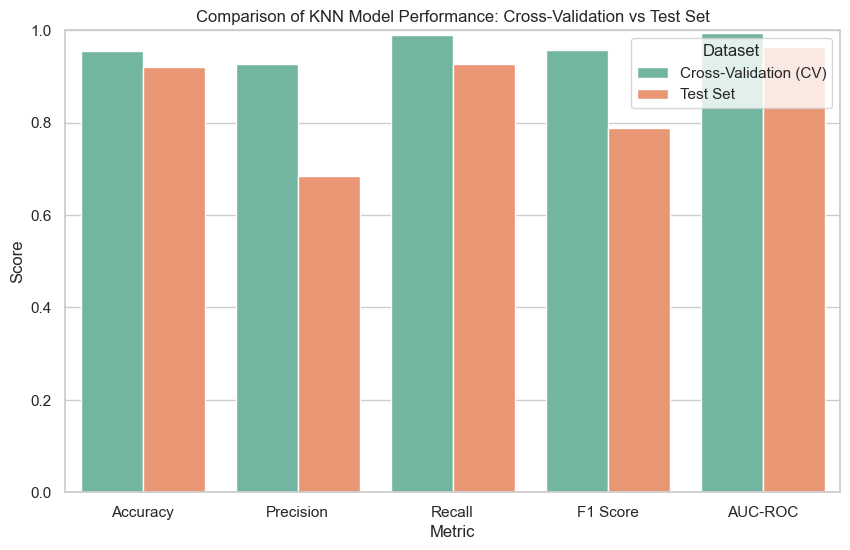

In [76]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_validate  # Added cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.3, random_state=42)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [5],
    'weights': ['uniform'],
}

# Step 4: Initialize the KNN model
knn = KNeighborsClassifier()

# Step 5: Use AUC-ROC as the scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Step 6: Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=2)

# Step 7: Fit the model to find the best parameters using the balanced training set
grid_search.fit(X_train_balanced, y_train_balanced)

# Step 8: Output the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Step 9: Train the KNN model with the best parameters
best_knn = grid_search.best_estimator_

# Step 10: Evaluate the model using cross-validation on the SMOTE-balanced data
cv_results = cross_validate(best_knn, X_train_balanced, y_train_balanced, cv=5,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], return_train_score=False)

# Calculate the mean of the cross-validation scores
cv_accuracy_mean = cv_results['test_accuracy'].mean()
cv_precision_mean = cv_results['test_precision'].mean()
cv_recall_mean = cv_results['test_recall'].mean()
cv_f1_mean = cv_results['test_f1'].mean()
cv_auc_roc_mean = cv_results['test_roc_auc'].mean()

# Step 11: Now, evaluate the tuned KNN model on the test set
y_pred = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]

# Step 12: Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc_test = roc_auc_score(y_test, y_pred_proba)

# Step 13: Print results for the tuned KNN model
print(f"KNN Tuned Model Results: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc_test:.4f}")
print(f"SVM Test Results: CV-Accuracy: {cv_accuracy_mean:.4f}, CV-Precision: {cv_precision_mean:.4f}, CV-Recall: {cv_recall_mean:.4f}, CV-F1 Score: {cv_f1_mean:.4f}, CV-AUC-ROC: {cv_auc_roc_mean:.4f}")
# Step 14: Create a comparison table including CV results
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Cross-Validation (CV)': [cv_accuracy_mean, cv_precision_mean, cv_recall_mean, cv_f1_mean, cv_auc_roc_mean],
    'Test Set': [accuracy, precision, recall, f1, auc_roc_test]
}

# Convert the dictionary to a pandas DataFrame
comparison_table = pd.DataFrame(comparison_data)

# Melt the DataFrame to make it easier to plot with seaborn
comparison_table_melted = comparison_table.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

# Step 15: Plot the comparison table
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=comparison_table_melted, palette='Set2')

# Add title and labels
plt.title('Comparison of KNN Model Performance: Cross-Validation vs Test Set')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for better visualization
plt.legend(title='Dataset')

# Show the plot
plt.show()


In [79]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# the best parameters already from GridSearch
svm_model = SVC(C=0.012, kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Cross-validated AUC-ROC score on training data
#svm_cv_auc_roc_scores = cross_val_score(svm_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')

# Fit the model on the full training data
svm_model.fit(X_train_balanced, y_train_balanced)

# Step 10: Evaluate the model using cross-validation on the SMOTE-balanced data
cv_results_svm = cross_validate(svm_model, X_train_balanced, y_train_balanced, cv=5,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], return_train_score=False)

# Calculate the mean of the cross-validation scores
cv_accuracy_mean_svm = cv_results_svm['test_accuracy'].mean()
cv_precision_mean_svm = cv_results_svm['test_precision'].mean()
cv_recall_mean_svm = cv_results_svm['test_recall'].mean()
cv_f1_mean_svm = cv_results_svm['test_f1'].mean()
cv_auc_roc_mean_svm = cv_results_svm['test_roc_auc'].mean()

# Predict on the test data
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate the test metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
auc_roc_test_svm = roc_auc_score(y_test, y_pred_proba_svm)

# Print the results
print(f"SVM Cross-validated AUC-ROC scores: {cv_accuracy_mean_svm}")
print(f"Mean AUC-ROC score: {cv_accuracy_mean_svm.mean()}")
print(f"SVM Test Results: Accuracy: {accuracy_svm:.4f}, Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}, F1 Score: {f1_svm:.4f}, AUC-ROC: {auc_roc_test_svm:.4f}")
print(f"SVM Test Results: CV-Accuracy: {cv_accuracy_mean_svm:.4f}, CV-Precision: {cv_precision_mean_svm:.4f}, CV-Recall: {cv_recall_mean_svm:.4f}, CV-F1 Score: {cv_f1_mean_svm:.4f}, CV-AUC-ROC: {cv_auc_roc_mean_svm:.4f}")

SVM Cross-validated AUC-ROC scores: 0.8902725856697821
Mean AUC-ROC score: 0.8902725856697821
SVM Test Results: Accuracy: 0.8981, Precision: 0.6277, Recall: 0.8676, F1 Score: 0.7284, AUC-ROC: 0.9712
SVM Test Results: CV-Accuracy: 0.8903, CV-Precision: 0.8986, CV-Recall: 0.8803, CV-F1 Score: 0.8890, CV-AUC-ROC: 0.9647


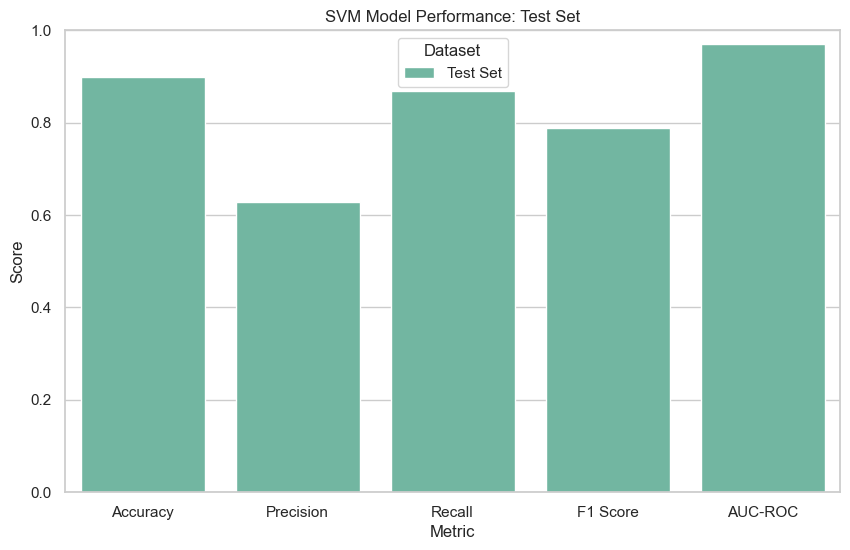

In [80]:
# Step 14: Create a comparison table including CV results
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
  
    'Test Set': [accuracy_svm, precision_svm, recall_svm, f1, auc_roc_test_svm]
}

# Convert the dictionary to a pandas DataFrame
comparison_table = pd.DataFrame(comparison_data)

# Melt the DataFrame to make it easier to plot with seaborn
comparison_table_melted = comparison_table.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

# Step 15: Plot the comparison table
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=comparison_table_melted, palette='Set2')

# Add title and labels
plt.title('SVM Model Performance: Test Set')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for better visualization
plt.legend(title='Dataset')

# Show the plot
plt.show()


In [81]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get the decision function scores
y_scores = svm_model.decision_function(X_test)

# Calculate precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best balance between precision and recall
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Best threshold based on F1 score: {best_threshold:.4f}")


Best threshold based on F1 score: 0.2514


In [82]:
# Apply the best threshold
y_pred_threshold = (y_scores >= best_threshold).astype(int)

# Evaluate the model with the new threshold
precision_svm_1 = precision_score(y_test, y_pred_threshold)
recall_svm_1 = recall_score(y_test, y_pred_threshold)
f1_svm_1 = f1_score(y_test, y_pred_threshold)
accuracy_svm_1 = accuracy_score(y_test, y_pred_threshold)
auc_roc_test_svm_1 = roc_auc_score(y_test, y_pred_threshold)
print(f"Adjusted SVM Test Results:  Accuracy: {accuracy_svm_1:.4f}, Precision: {precision_svm_1:.4f}, Recall: {recall_svm_1:.4f}, F1 Score: {f1_svm_1:.4f}")


Adjusted SVM Test Results:  Accuracy: 0.9352, Precision: 0.8333, Recall: 0.7353, F1 Score: 0.7812


In [83]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define stratified k-fold
skf = StratifiedKFold(n_splits=5)

# Initialize lists to hold the results
precisions_svm_2 = []
recalls_svm_2 = []
f1_scores_svm_2 = []
accuracy_svm_2 = []
auc_roc_test_svm_2 = []

for train_index, val_index in skf.split(X_train_balanced, y_train_balanced):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_index], X_train_balanced.iloc[val_index]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]
    
    # Train the model on this fold
    svm_model.fit(X_train_fold, y_train_fold)
    
    # Get the decision function scores for the validation set
    y_scores_val = svm_model.decision_function(X_val_fold)
    
    # Apply the adjusted threshold
    y_pred_val = (y_scores_val >= best_threshold).astype(int)
    
    # Calculate precision, recall, and F1 score
    precisions_svm_2.append(precision_score(y_val_fold, y_pred_val))
    recalls_svm_2.append(recall_score(y_val_fold, y_pred_val))
    f1_scores_svm_2.append(f1_score(y_val_fold, y_pred_val))
    accuracy_svm_2.append(accuracy_score(y_val_fold, y_pred_val))
    auc_roc_test_svm_2.append(roc_auc_score(y_val_fold, y_pred_val))



# Average results across folds
print(f"Cross-validated Accuracy: {np.mean(accuracy_svm_2):.4f}")
print(f"Cross-validated Precision: {np.mean(precisions_svm_2):.4f}")
print(f"Cross-validated Recall: {np.mean(recalls_svm_2):.4f}")
print(f"Cross-validated F1 Score: {np.mean(f1_scores_svm_2):.4f}")
print(f"Cross-validated AUC-ROC scores: {np.mean(auc_roc_test_svm_2):.4f}")
cv_accuracy_mean_svm_2 = np.mean(accuracy_svm_2)
cv_precision_mean_svm_2 = np.mean(precisions_svm_2)
cv_recall_mean_svm_2 = np.mean(recalls_svm_2)
cv_f1_mean_svm_2 = np.mean(f1_scores_svm_2)
cv_auc_roc_test_svm_2= np.mean(auc_roc_test_svm_2)

Cross-validated Accuracy: 0.8734
Cross-validated Precision: 0.9677
Cross-validated Recall: 0.7731
Cross-validated F1 Score: 0.8591
Cross-validated AUC-ROC scores: 0.8735


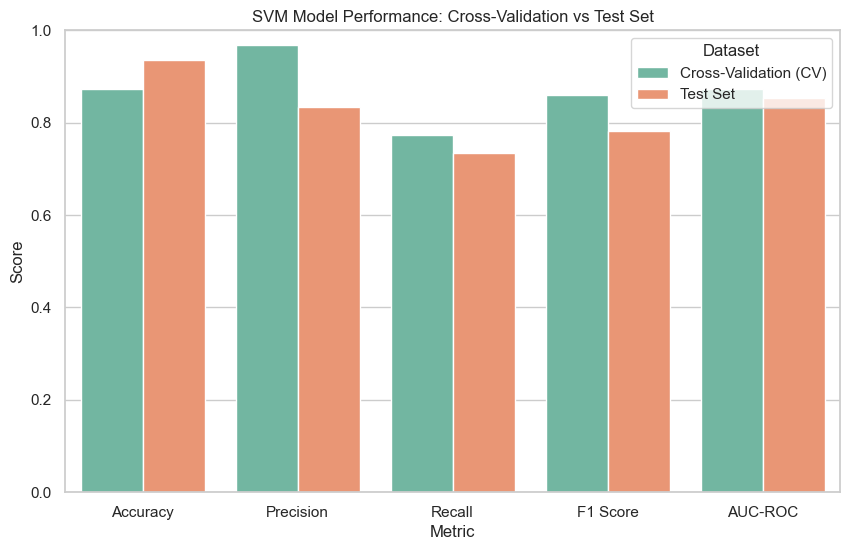

In [84]:
# Step 14: Create a comparison table including CV results
comparison_data_svm = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Cross-Validation (CV)': [cv_accuracy_mean_svm_2, cv_precision_mean_svm_2, cv_recall_mean_svm_2, cv_f1_mean_svm_2, cv_auc_roc_test_svm_2],
    'Test Set': [accuracy_svm_1, precision_svm_1, recall_svm_1, f1_svm_1, auc_roc_test_svm_1]
}

# Convert the dictionary to a pandas DataFrame
comparison_table = pd.DataFrame(comparison_data_svm)

# Melt the DataFrame to make it easier to plot with seaborn
comparison_table_melted = comparison_table.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

# Step 15: Plot the comparison table
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=comparison_table_melted, palette='Set2')

# Add title and labels
plt.title('SVM Model Performance: Cross-Validation vs Test Set')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for better visualization
plt.legend(title='Dataset')

# Show the plot
plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [86]:
# X_train_balanced and y_train_balanced are your training data from SMOTE

# Reduce the dimensionality of your data to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_balanced)

# Train an SVM on the 2D data
svm_model = SVC(C=0.012, kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_2d, y_train_balanced)


SVC(C=0.012, class_weight='balanced', probability=True, random_state=42)

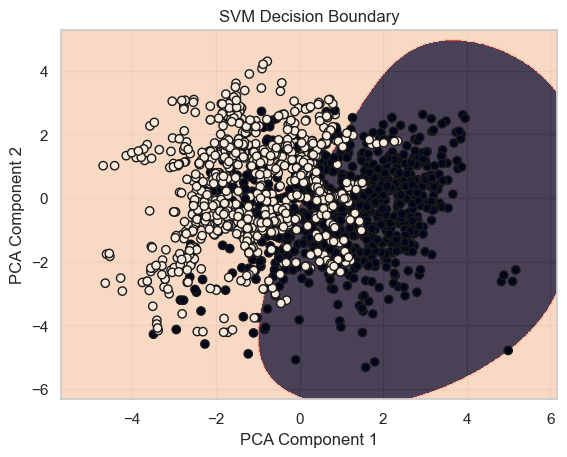

In [87]:
# Create a mesh to plot in
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot decision boundary
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_balanced, edgecolors='k', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SVM Decision Boundary')
plt.show()


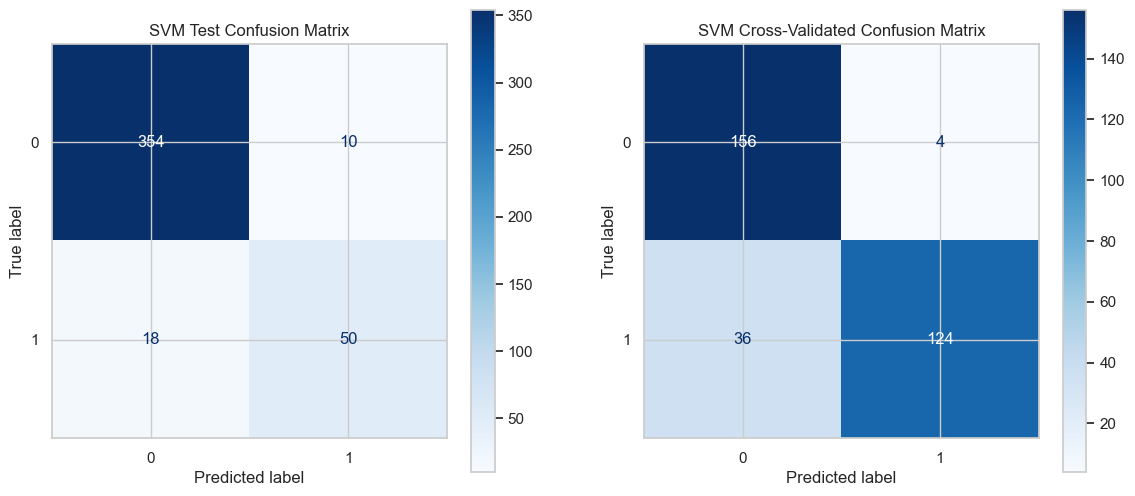

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix for normal SVM test results
cm_test = confusion_matrix(y_test, y_pred_threshold)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])

# Confusion matrix for cross-validated results
cm_cv_total = np.zeros((2, 2))

for train_index, val_index in skf.split(X_train_balanced, y_train_balanced):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_index], X_train_balanced.iloc[val_index]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]

    # Train the model on this fold
    svm_model.fit(X_train_fold, y_train_fold)

    # Get the decision function scores for the validation set
    y_scores_val = svm_model.decision_function(X_val_fold)

    # Apply the adjusted threshold
    y_pred_val = (y_scores_val >= best_threshold).astype(int)

    # Calculate the confusion matrix for this fold
    cm_cv = confusion_matrix(y_val_fold, y_pred_val)
    cm_cv_total += cm_cv

# Average confusion matrix
cm_cv_avg = cm_cv_total / skf.get_n_splits()
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv_avg.astype(int), display_labels=[0, 1])

# Plot both confusion matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the confusion matrix for the normal SVM test results
disp_test.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("SVM Test Confusion Matrix")

# Plot the confusion matrix for the cross-validated results
disp_cv.plot(ax=ax[1], cmap='Blues')
ax[1].set_title("SVM Cross-Validated Confusion Matrix")

# Display the plots
plt.show()

# Print matrices for reference
#print("Confusion Matrix for SVM Test Results:")
#print(cm_test)

#print("\nConfusion Matrix for Cross-Validated SVM Results:")
#print(cm_cv_avg.astype(int))


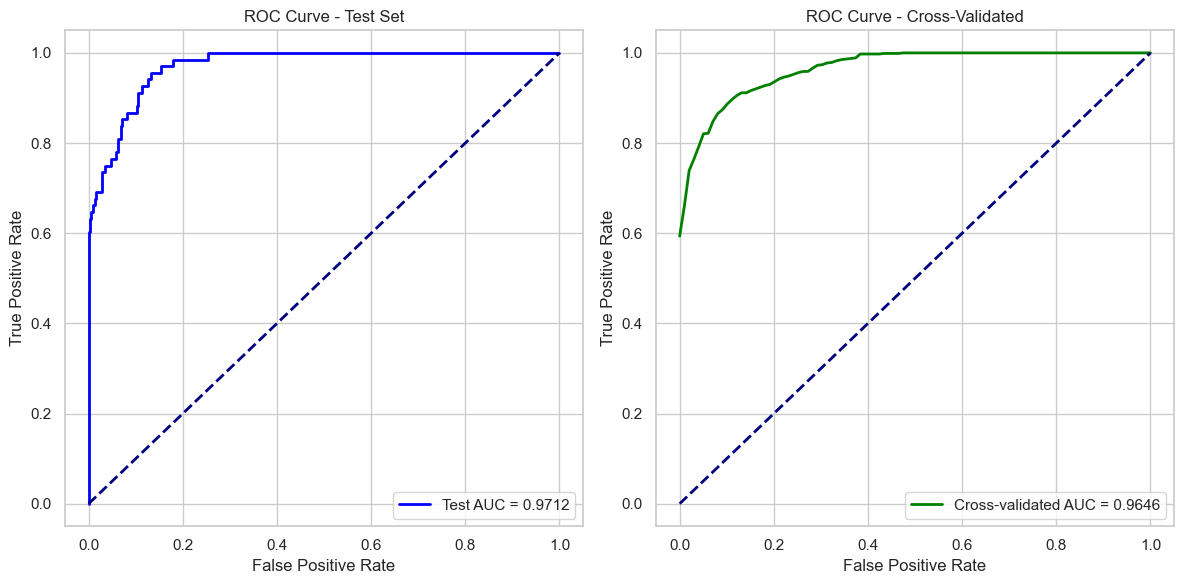

In [89]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve for Test Set
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_test = auc(fpr, tpr)

# ROC Curve for Cross-Validated Model
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, val_index) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_index], X_train_balanced.iloc[val_index]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]
    svm_model.fit(X_train_fold, y_train_fold)
    y_proba_val = svm_model.predict_proba(X_val_fold)[:, 1]
    fpr_fold, tpr_fold, _ = roc_curve(y_val_fold, y_proba_val)
    tprs.append(np.interp(mean_fpr, fpr_fold, tpr_fold))
    aucs.append(auc(fpr_fold, tpr_fold))

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Test AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(mean_fpr, mean_tpr, color='green', lw=2, label=f'Cross-validated AUC = {mean_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cross-Validated')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


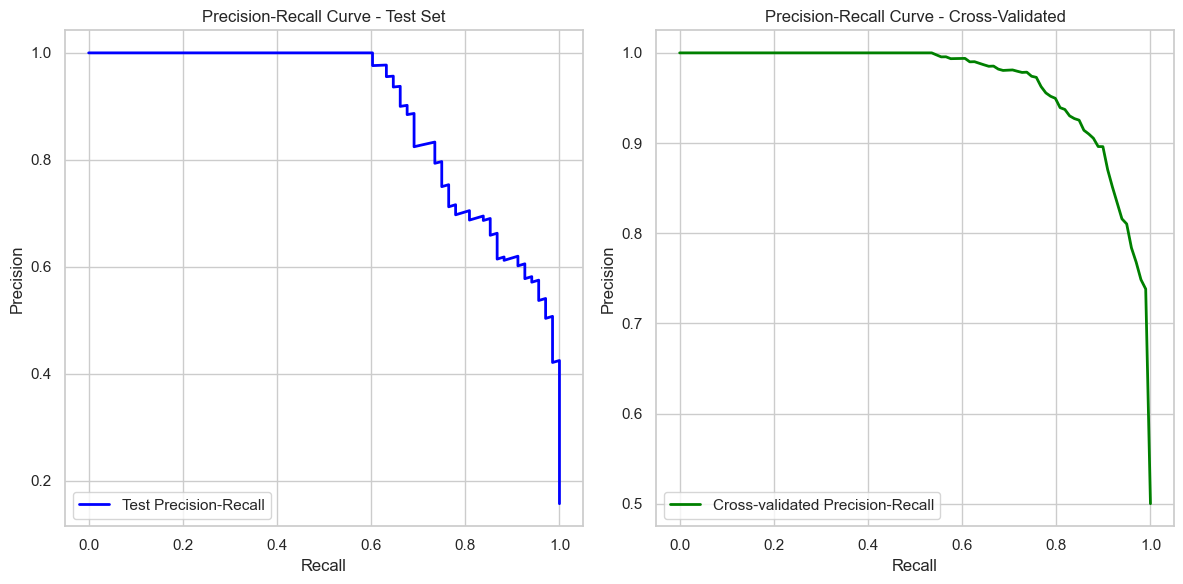

In [90]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Precision-Recall Curve for Test Set
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_svm)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_test, precision_test, color='blue', lw=2, label='Test Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")

# Precision-Recall Curve for Cross-Validated Model
mean_recalls = np.linspace(0, 1, 100)  # Define a common set of recall points
mean_precisions = []

for i, (train_index, val_index) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_index], X_train_balanced.iloc[val_index]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]
    svm_model.fit(X_train_fold, y_train_fold)
    y_proba_val = svm_model.predict_proba(X_val_fold)[:, 1]
    precision_val, recall_val, _ = precision_recall_curve(y_val_fold, y_proba_val)

    # Interpolate to the common recall points
    precision_interp = np.interp(mean_recalls, recall_val[::-1], precision_val[::-1])
    mean_precisions.append(precision_interp)

# Average the interpolated precision values
mean_precision = np.mean(mean_precisions, axis=0)

plt.subplot(1, 2, 2)
plt.plot(mean_recalls, mean_precision, color='green', lw=2, label='Cross-validated Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Cross-Validated')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [91]:
#!pip install scikit-learn==0.24.2


In [92]:
from sklearn.svm import SVC

# Train the SVM model with probability enabled
svm_model = SVC(C=0.012, kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Fit the model on the training data
svm_model.fit(X_train_balanced, y_train_balanced)


SVC(C=0.012, class_weight='balanced', probability=True, random_state=42)

In [93]:
#!pip install ipywidgets --upgrade


In [95]:
'''import shap
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
# Create a SHAP explainer for the SVM model
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train_balanced[:100])  # Sampling to reduce computation

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the summary plot (a bar plot to rank features by importance)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train_balanced.columns)
'''

'import shap\nimport matplotlib.pyplot as plt\nimport tqdm as notebook_tqdm\n# Create a SHAP explainer for the SVM model\nexplainer = shap.KernelExplainer(svm_model.predict_proba, X_train_balanced[:100])  # Sampling to reduce computation\n\n# Compute SHAP values for the test set\nshap_values = explainer.shap_values(X_test)\n\n# Plot the summary plot (a bar plot to rank features by importance)\nshap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train_balanced.columns)\n'

In [ ]:
import joblib

# Save the model
joblib.dump(svm_model, 'svm_model.pkl')

# If preprocessing is separate, save the scaler
joblib.dump(scaler, 'scaler.pkl')


In [339]:
from graphviz import Digraph

# Initialize a directed graph
dot = Digraph(comment='Injury Prediction Process')

# Set the style and color for the nodes and edges
dot.attr('node', style='filled', color='lightblue', shape='box', fontname="Helvetica", fontsize="10")
dot.attr('edge', color='gray', fontname="Helvetica", fontsize="10")

# Adding nodes with descriptions
dot.node('A', 'Data Collection', fillcolor='lightyellow')
dot.node('B', 'Data Cleaning & Preparation', fillcolor='lightgreen')
dot.node('C', 'Data Integration', fillcolor='lightcoral')
dot.node('D', 'Feature Engineering', fillcolor='lightblue')
dot.node('E', 'Exploratory Data Analysis (EDA)', fillcolor='lightpink')
dot.node('F', 'Handling Imbalanced Data', fillcolor='lightcyan')
dot.node('G', 'Model Training with Multiple Sampling Techniques', fillcolor='lightgoldenrod')

dot.node('H1', 'Random Forest', fillcolor='lightsteelblue')
dot.node('H2', 'Support Vector Machine (SVM)', fillcolor='lightsteelblue')
dot.node('H3', 'K-Nearest Neighbors (KNN)', fillcolor='lightsteelblue')
dot.node('H4', 'XGBoost', fillcolor='lightsteelblue')

dot.node('I1', 'Selected for SMOTE: KNN', fillcolor='lightgoldenrod')
dot.node('I2', 'Selected for SMOTE: SVM', fillcolor='lightgoldenrod')

dot.node('J1', 'Hyperparameter Tuning: KNN', fillcolor='lightcoral')
dot.node('J2', 'Hyperparameter Tuning SVM', fillcolor='lightcoral')

dot.node('K1', 'Cross-Validation: KNN', fillcolor='lightgreen')
dot.node('K2', 'Cross-Validation: SVM', fillcolor='lightgreen')

dot.node('L', 'Selected Model: SVM', fillcolor='lightyellow')
dot.node('M', 'SVM Threshold Optimization', fillcolor='lightsalmon')
dot.node('N', 'Results & Discussion', fillcolor='lightgray')

# Adding edges with labels to describe transitions
dot.edge('A', 'B', label='Raw Data Collected')
dot.edge('B', 'C', label='Cleaned Data Ready')
dot.edge('C', 'D', label='Integrated Data Set')
dot.edge('D', 'E', label='Features Extracted')
dot.edge('E', 'F', label='Analysis Done')
dot.edge('F', 'G', label='Balanced Dataset with Sampling Techniques')

# Connect from Model Training to each model
dot.edge('G', 'H3', label='Train KNN')
dot.edge('G', 'H2', label='Train SVM')
dot.edge('G', 'H1', label='Train Random Forest')
dot.edge('G', 'H4', label='Train XGBoost')

# Selection after initial evaluation
dot.edge('H3', 'I1', label='Selected for SMOTE')
dot.edge('H2', 'I2', label='Selected for SMOTE')

# Cross-validation process
dot.edge('I1', 'J1', label='Hyperparameter Tuning')
dot.edge('I2', 'J2', label='Hyperparameter Tuning')

# Hyperparameter tuning
dot.edge('J1', 'K1', label='Cross-Validation')
dot.edge('J2', 'K2', label='Cross-Validation')

# Final model selection
dot.edge('K2', 'L', label='SVM Selected after Hyperparameter Tuning')
dot.edge('L', 'M', label='Threshold Optimization')
dot.edge('M', 'N', label='Final Results & Discussion')

# Render the flowchart and save it
dot.render('injury_prediction_process_with_hyperparameter_tuning_1.gv', view=True)


'injury_prediction_process_with_hyperparameter_tuning_1.gv.pdf'